```python
file1 \_ |-----------------------------------|   -+-
file2 \_ |-----------------------------------|    |   training data
file3 \_ |-----------------------------------|    |        80%
file4 \_ |-----------------------------------|    |
                                                 -+-
file5 \_ |-----------------------------------|    |  validation data
file6 \_ |-----------------------------------|    |        20%
         |-----------------------------------|   -+-
```

In [1]:
import os
import glob

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

from utils.MovingAverager import *
from collections import defaultdict

# 讀檔

In [2]:
validation_traj = np.load(f'./window_5/all_user_match_data.npy', allow_pickle=True)

'cord_y', 'cord_x', 'times', 'acc_x', 'acc_y', 'acc_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'mag_x', 'mag_y', 'mag_z', 'mag_t'

In [3]:
posture_data = defaultdict(list)

valid_data = validation_traj.item()
for user_name in valid_data.keys():
    for path_name in valid_data[user_name].keys():
        for posture_name in valid_data[user_name][path_name].keys():
            data = valid_data[user_name][path_name][posture_name]
            pos = (data[:, [0, 1]] + np.array((1, 1))) * 0.6
            mag = data[:, [6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]

            pos_mag = np.concatenate((pos, mag), axis=-1)
            posture_data[posture_name].append(pos_mag)

In [4]:
def split_traj(trajs, length=20):
    sp_traj = []
    for traj in trajs:
        for i in range(len(traj) - length + 1):
            sp_traj.append(traj[i:i+length])
    return np.array(sp_traj)

In [5]:
prep_valid_front_pocket_traj = split_traj(posture_data['front_pocket'])
prep_valid_horizontal_traj = split_traj(posture_data['horizontal'])
prep_valid_pocket_traj = split_traj(posture_data['pocket'])
prep_valid_swing_traj = split_traj(posture_data['swing'])
prep_valid_target_traj = split_traj(posture_data['target'])

In [6]:
# def expand_seq_features(seq):
#     ### neighbors
#     s_cord = seq[:, :, 0:2]
#     s_mag = seq[:, :, 2:5]
    
#     s_magT = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2) + np.power(s_mag[:, :, 2:3], 2))
#     s_magH = np.sqrt(np.power(s_mag[:, :, 0:1], 2) + np.power(s_mag[:, :, 1:2], 2))  # magH
#     s_elevation_angle = np.arccos(s_magH / s_magT) / np.pi * 180  # angle
#     # n_azimuth_angle = 0
    
#     print(s_cord.shape, s_mag.shape, s_magT.shape, s_magH.shape, s_elevation_angle.shape)
#     s_new = np.concatenate([s_cord, s_mag, s_magT, s_magH, s_elevation_angle], axis=-1)
    
#     return s_new

In [7]:
# prep_valid_front_pocket_traj = expand_seq_features(prep_valid_front_pocket_traj)
# prep_valid_horizontal_traj = expand_seq_features(prep_valid_horizontal_traj)
# prep_valid_pocket_traj = expand_seq_features(prep_valid_pocket_traj)
# prep_valid_swing_traj = expand_seq_features(prep_valid_swing_traj)
# prep_valid_target_traj = expand_seq_features(prep_valid_target_traj)

In [8]:
prep_valid_front_pocket_traj.shape, prep_valid_horizontal_traj.shape, prep_valid_pocket_traj.shape, prep_valid_swing_traj.shape, prep_valid_target_traj.shape

((123, 20, 12), (123, 20, 12), (123, 20, 12), (123, 20, 12), (123, 20, 12))

In [9]:
datapoint_per_second = 20
duration = 2
seq_len = 10
classes = {0: 'target', 1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing'}

# 建立dataloader

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [11]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [12]:
class FirstDerivativeLoss(nn.Module):
    def __init__(self, weight=None, size_average=None, reduce=None, reduction='mean'):
        super(FirstDerivativeLoss, self).__init__()

    def forward(self, source, target):
        # calculate the first derivative
        source_o = torch.reshape(source, (len(source), -1))
        target_o = torch.reshape(target, (len(target), -1))
        d_source = source_o[1:] - source_o[:-1]
        d_target = target_o[1:] - target_o[:-1]
        deriv = d_source - d_target

        # calculate the loss as the mean squared error of the derivative
        loss = torch.mean(torch.pow(deriv, 2))

        return loss

In [13]:
def generator_loss(z_imu, target_imu, predict_mag, target_mag, source_total_mag, target_total_mag):
    imu_loss = mse_loss(z_imu, target_imu)
    mag_loss = mse_loss(predict_mag, target_mag)
    d1_loss = div_loss(predict_mag, target_mag)
    
    pred_total_mag = torch.sqrt(torch.sum(torch.pow(predict_mag, 2), dim=-1))
    
#     print(source_total_mag.shape, target_total_mag.shape, pred_total_mag.shape)
#     print(source_total_mag[0])
#     print(target_total_mag[0])
#     print(pred_total_mag[0])
    
    smag_limitation_loss = torch.mean(torch.abs(pred_total_mag - source_total_mag))
    tmag_limitation_loss = torch.mean(torch.abs(pred_total_mag - target_total_mag))

    total_loss = imu_loss + mag_loss + d1_loss + smag_limitation_loss * 0.25 + tmag_limitation_loss * 0.75
    return total_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss)

# def discriminator_loss(d_real, d_fake):
#     real_loss = bce_loss(d_real, torch.ones_like(d_real))
#     fake_loss = bce_loss(d_fake, torch.zeros_like(d_fake))

#     return real_loss + fake_loss

In [14]:
# train
t_data = np.concatenate((prep_valid_front_pocket_traj[0::2], prep_valid_horizontal_traj[0::2], prep_valid_pocket_traj[0::2], prep_valid_swing_traj[0::2]))
t_target_data = np.concatenate((prep_valid_target_traj[0::2], prep_valid_target_traj[0::2], prep_valid_target_traj[0::2], prep_valid_target_traj[0::2]))

train_source_data = t_data
train_source_label = (np.arange(4) + 1).repeat(62)
train_target_data = t_target_data
train_target_label = np.zeros((62 * 4, ))
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# valid
v_data = np.concatenate((prep_valid_front_pocket_traj[1::2], prep_valid_horizontal_traj[1::2], prep_valid_pocket_traj[1::2], prep_valid_swing_traj[1::2]))
v_target_data = np.concatenate((prep_valid_target_traj[1::2], prep_valid_target_traj[1::2], prep_valid_target_traj[1::2], prep_valid_target_traj[1::2]))

valid_source_data = v_data
valid_source_label = (np.arange(4) + 1).repeat(61)
valid_target_data = v_target_data
valid_target_label = np.zeros((61 * 4, ))
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=64)

In [15]:
batch = next(iter(train_loader))

In [16]:
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()
bce_loss = torch.nn.BCELoss()
div_loss = FirstDerivativeLoss()

In [17]:
def get_tgt_mask(size) -> torch.tensor:
    # Generates a squeare matrix where the each row allows one word more to be seen
    mask = torch.tril(torch.ones(size, size) == 1) # Lower triangular matrix
    mask = mask.float()
    mask = mask.masked_fill(mask == 0, float('-inf')) # Convert zeros to -inf
    mask = mask.masked_fill(mask == 1, float(0.0)) # Convert ones to 0

    # EX for size=5:
    # [[0., -inf, -inf, -inf, -inf],
    #  [0.,   0., -inf, -inf, -inf],
    #  [0.,   0.,   0., -inf, -inf],
    #  [0.,   0.,   0.,   0., -inf],
    #  [0.,   0.,   0.,   0.,   0.]]

    return mask

In [18]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.imu_layer = nn.Sequential(
            nn.Linear(6, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 64),
            nn.LeakyReLU(),
        )
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        self.pos_encoder = PositionalEncoding(64, 0.1)
        
        self.encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        self.nn = nn.Sequential(
            nn.Linear(64, 32),
            nn.LeakyReLU(),
            nn.Linear(32, 6),
            nn.LeakyReLU(),
        )
        
        self.decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=1)
        
        self.mag_last = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 3),
        )
        
    def forward(self, source_imu, source_mag):
        
        ### step 1
        h_imu = self.imu_layer(source_imu)
        h_imu = self.pos_encoder(h_imu)
        
        h_mag = self.mag_layer(source_mag)
        h_mag = self.pos_encoder(h_mag)
        
        ### step 2
        z = self.encoder(h_imu)
        z_imu = self.nn(z)
        
        ### step 3
        pred_latent = self.decoder(h_mag, z)
        pred_mag = self.mag_last(pred_latent)
        
        return z_imu, pred_mag
        

In [19]:
model = NotSimpleTransformer(seq_len=seq_len, num_of_classes=num_of_classes).to(device)
# discriminator = Discriminator(chunk_size=chunk_size, seq_len=seq_len).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.00005)
# optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.000025)

In [20]:
output = model(torch.empty(16, 10, 6).to(device), torch.empty(16, 10, 3).to(device))
output[0].shape, output[1].shape

(torch.Size([16, 10, 6]), torch.Size([16, 10, 3]))

In [21]:
from torchinfo import summary
summary(model, input_size=[(1, 10, 6), (1, 10, 3)])

Layer (type:depth-idx)                        Output Shape              Param #
NotSimpleTransformer                          [1, 10, 6]                --
├─Sequential: 1-1                             [1, 10, 64]               --
│    └─Linear: 2-1                            [1, 10, 32]               224
│    └─LeakyReLU: 2-2                         [1, 10, 32]               --
│    └─Linear: 2-3                            [1, 10, 64]               2,112
│    └─LeakyReLU: 2-4                         [1, 10, 64]               --
├─PositionalEncoding: 1-2                     [1, 10, 64]               --
│    └─Dropout: 2-5                           [1, 10, 64]               --
├─Sequential: 1-3                             [1, 10, 64]               --
│    └─Linear: 2-6                            [1, 10, 16]               64
│    └─LeakyReLU: 2-7                         [1, 10, 16]               --
│    └─Linear: 2-8                            [1, 10, 64]               1,088
│    └─LeakyR

In [22]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [23]:
def train(dataloader, draw=False):
    model.train()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []

    for source_data, source_label, target_data, target_label in dataloader:
        optimizer.zero_grad()

        source_data = source_data.to(device)
        source_imu = source_data[:, :, 2:8] + torch.randn_like(source_data[:, :, 2:8]) * 0.25
        source_mag = source_data[:, :, 8:11] + torch.randn_like(source_data[:, :, 8:11]) * 0.5
        source_total_mag = source_data[:, :, 11]
        
        target_data = target_data.to(device)
        target_imu = target_data[:, :, 2:8]
        target_mag = target_data[:, :, 8:11]
        target_total_mag = target_data[:, :, 11]

        # generate mag
        z_imu, predict_mag = model(source_imu, source_mag)
        
        # generator loss
        gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                              source_total_mag, target_total_mag)
        
        # backward
        gen_loss.backward()
        optimizer.step()
        
        # record loss
        g_losses.append(gen_loss.item())
        imu_losses.append(imu_loss.item())
        mag_losses.append(mag_loss.item())
        d1_losses.append(d1_loss.item())
        lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

In [24]:
def evalute(dataloader, draw=False):
    model.eval()

    g_losses = []
    imu_losses = []
    mag_losses = []
    d1_losses = []
    lim_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_imu = source_data[:, :, 2:8]
            source_mag = source_data[:, :, 8:11]
            source_total_mag = source_data[:, :, 11]

            target_data = target_data.to(device)
            target_imu = target_data[:, :, 2:8]
            target_mag = target_data[:, :, 8:11]
            target_total_mag = target_data[:, :, 11]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
            gen_loss, (imu_loss, mag_loss, d1_loss, smag_limitation_loss, tmag_limitation_loss) = generator_loss(z_imu, target_imu, predict_mag, target_mag,
                                                                                                  source_total_mag, target_total_mag)

            # record loss
            g_losses.append(gen_loss.item())
            imu_losses.append(imu_loss.item())
            mag_losses.append(mag_loss.item())
            d1_losses.append(d1_loss.item())
            lim_loss.append([smag_limitation_loss.item(), tmag_limitation_loss.item()])
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_mag[0].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(g_losses), np.mean(imu_losses), np.mean(mag_losses), np.mean(d1_losses), np.mean(lim_loss, axis=0)

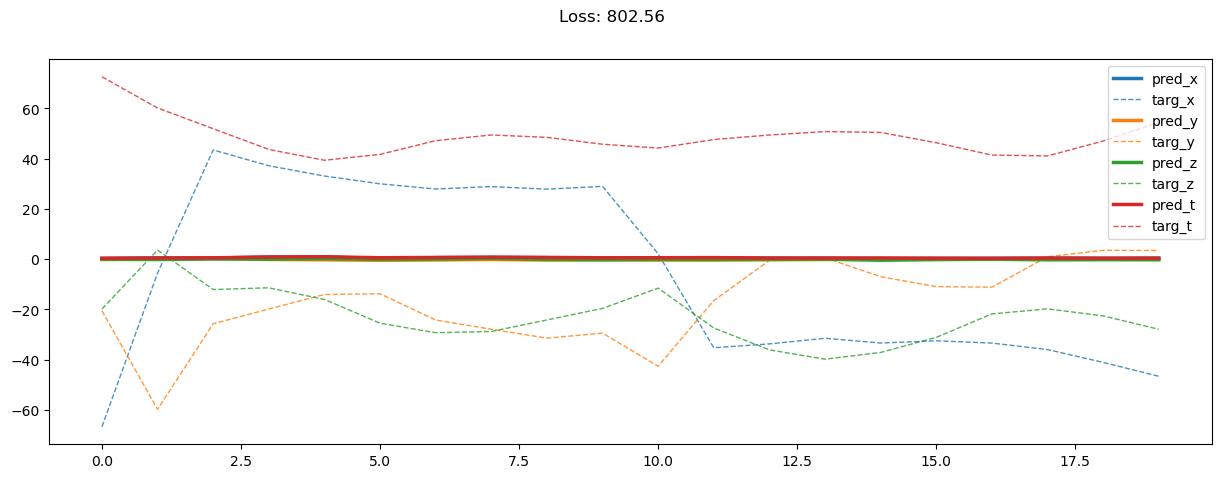

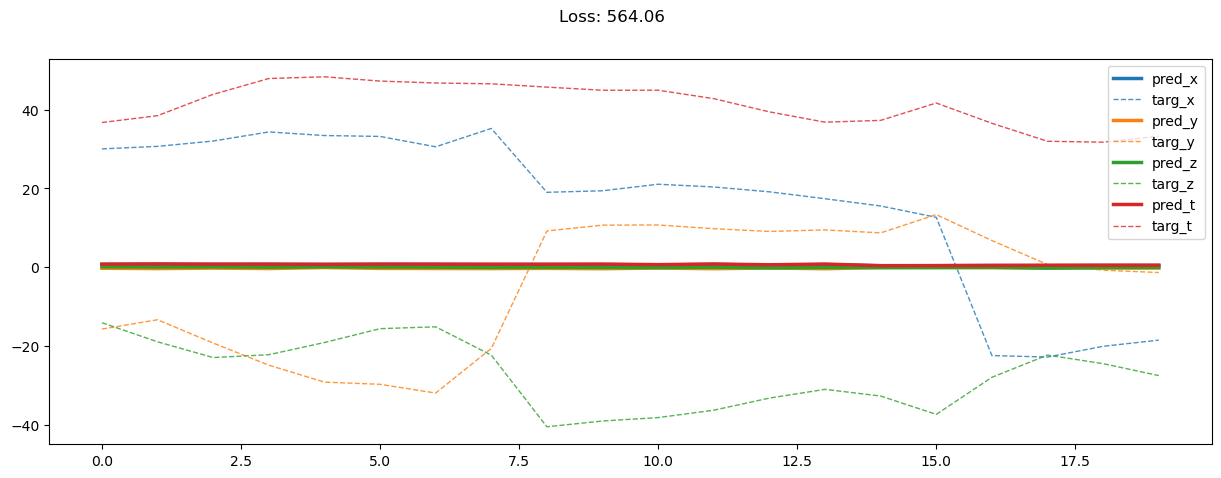

00500: train loss:  906.166, imu loss:  0.309, mag loss:  330.700, div loss:  549.954, slim:  25.241, tlim:  25.190
       valid loss:  644.197, imu loss:  0.315, mag loss:  303.442, div loss:  316.306, slim:  24.056, tlim:  24.160


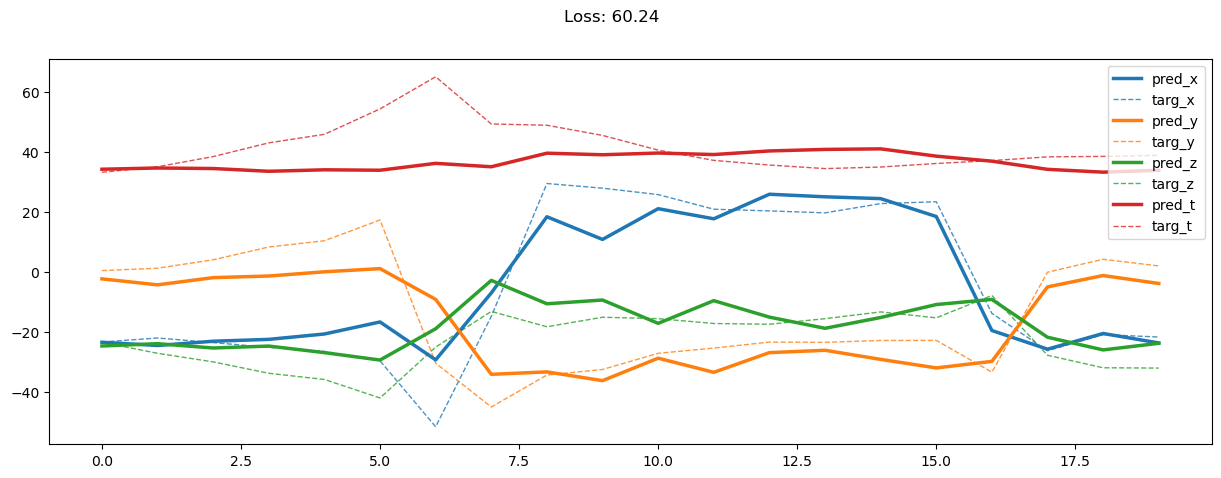

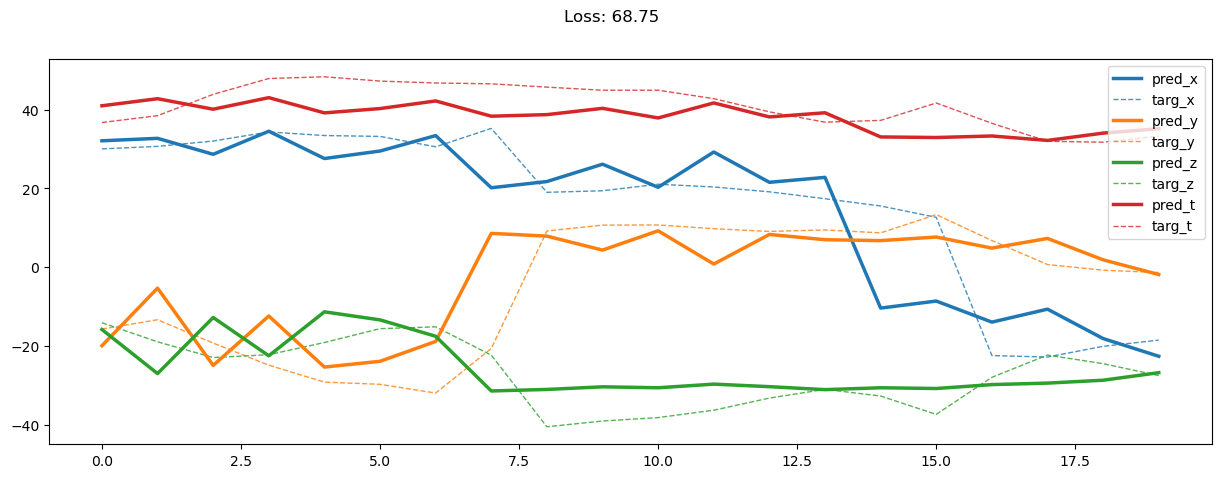

01000: train loss:  508.872, imu loss:  0.304, mag loss:  165.638, div loss:  332.936, slim:  10.570, tlim:  9.802
       valid loss:  344.164, imu loss:  0.310, mag loss:  133.275, div loss:  201.866, slim:  9.335, tlim:  8.505
01500: train loss:  408.433, imu loss:  0.299, mag loss:  133.856, div loss:  267.106, slim:  8.073, tlim:  6.873
       valid loss:  270.581, imu loss:  0.305, mag loss:  101.472, div loss:  162.455, slim:  7.328, tlim:  6.024


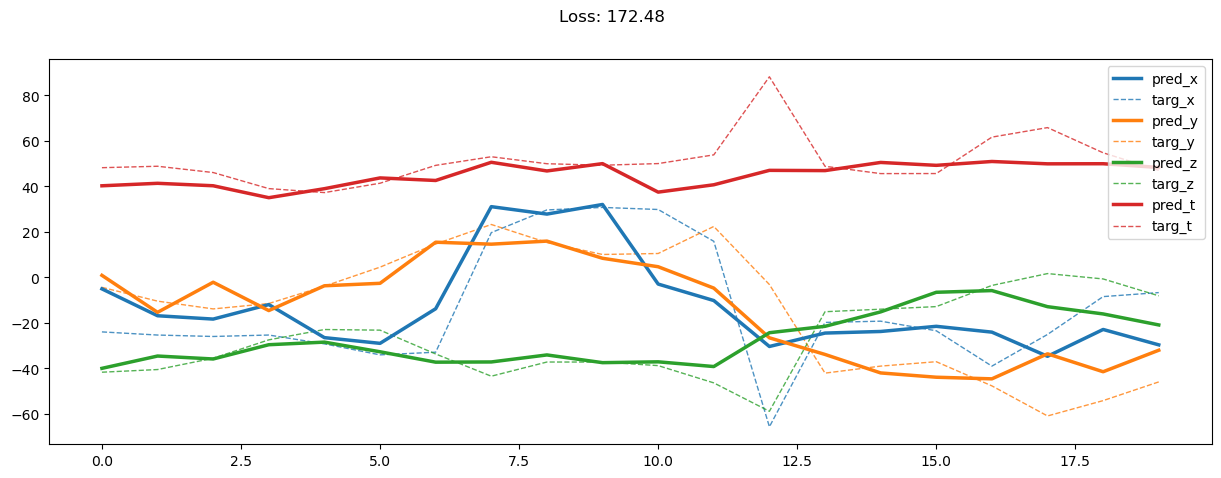

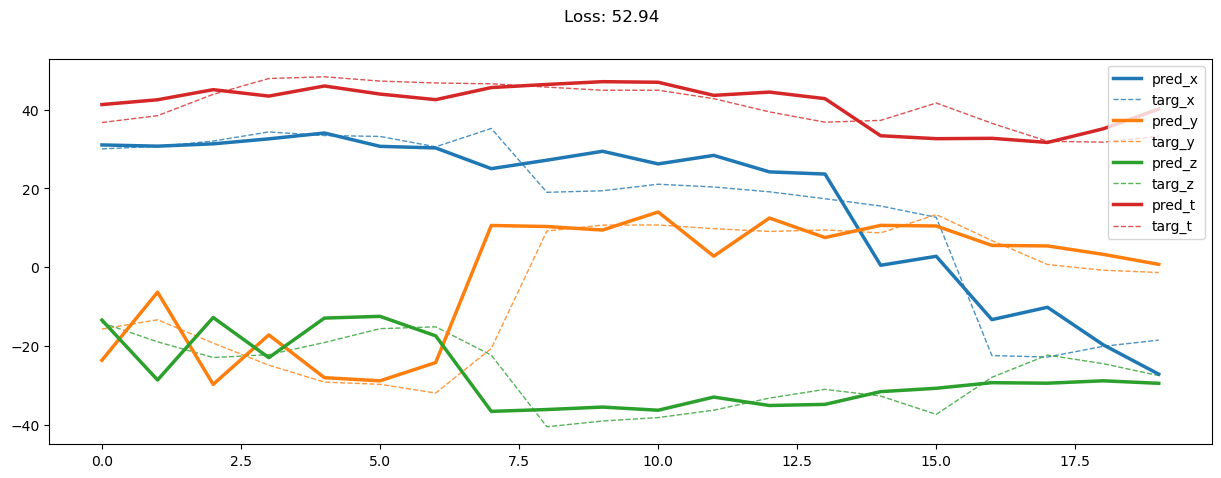

02000: train loss:  358.274, imu loss:  0.297, mag loss:  120.392, div loss:  231.067, slim:  7.394, tlim:  6.226
       valid loss:  227.674, imu loss:  0.302, mag loss:  85.270, div loss:  136.520, slim:  6.650, tlim:  5.226
02500: train loss:  337.341, imu loss:  0.295, mag loss:  110.767, div loss:  219.903, slim:  7.267, tlim:  6.078
       valid loss:  199.923, imu loss:  0.300, mag loss:  74.093, div loss:  120.357, slim:  6.277, tlim:  4.805


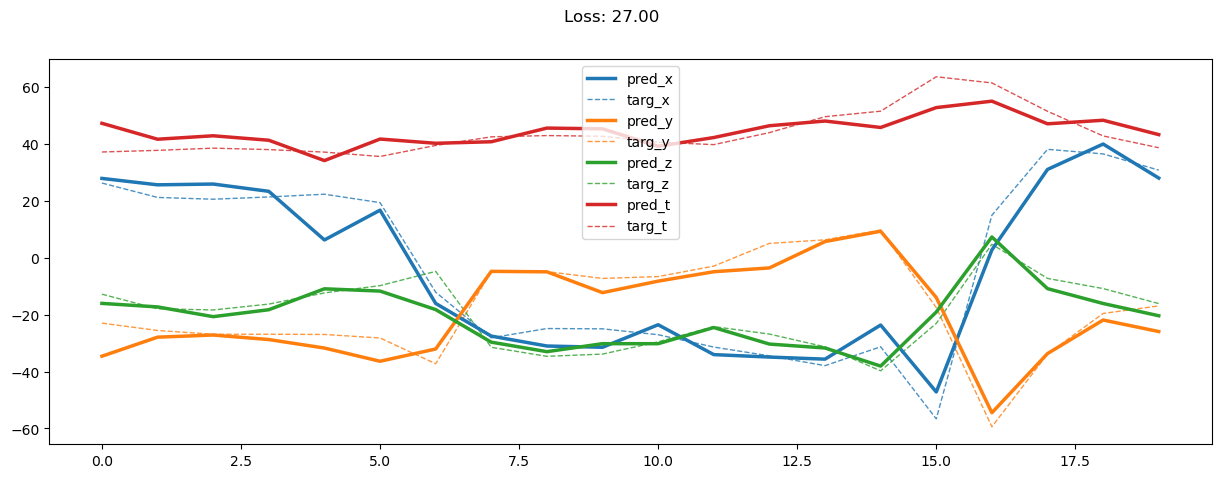

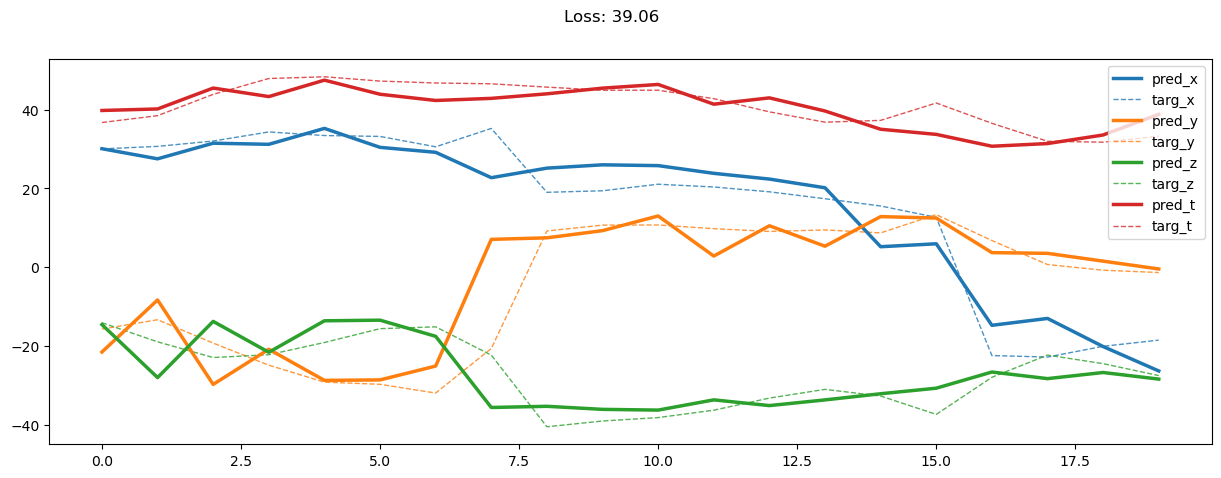

03000: train loss:  311.369, imu loss:  0.295, mag loss:  101.414, div loss:  203.585, slim:  7.002, tlim:  5.767
       valid loss:  176.972, imu loss:  0.299, mag loss:  64.834, div loss:  106.985, slim:  5.996, tlim:  4.474
03500: train loss:  289.512, imu loss:  0.294, mag loss:  94.690, div loss:  188.817, slim:  6.716, tlim:  5.377
       valid loss:  157.062, imu loss:  0.297, mag loss:  57.091, div loss:  95.124, slim:  5.753, tlim:  4.147


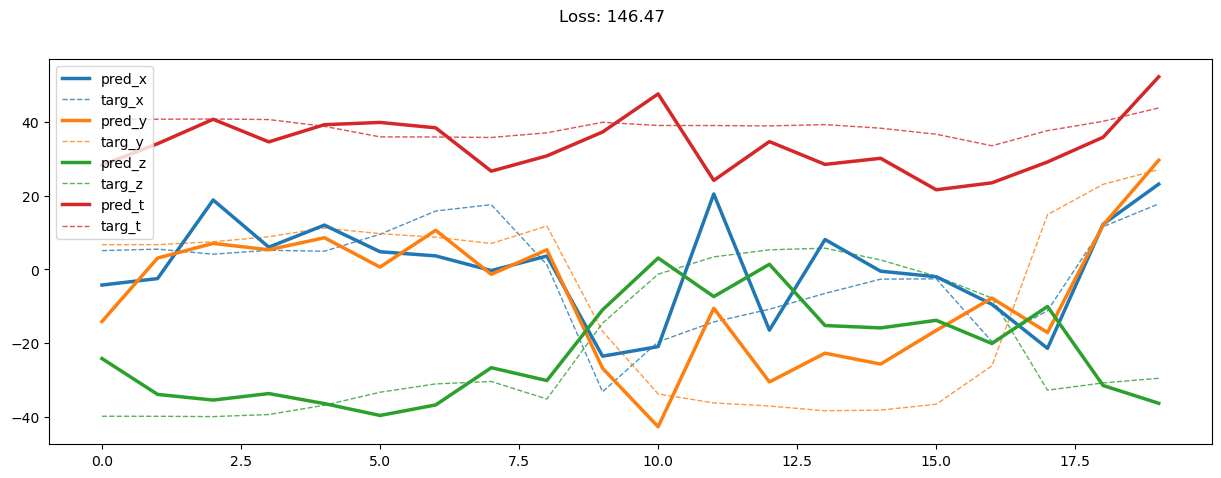

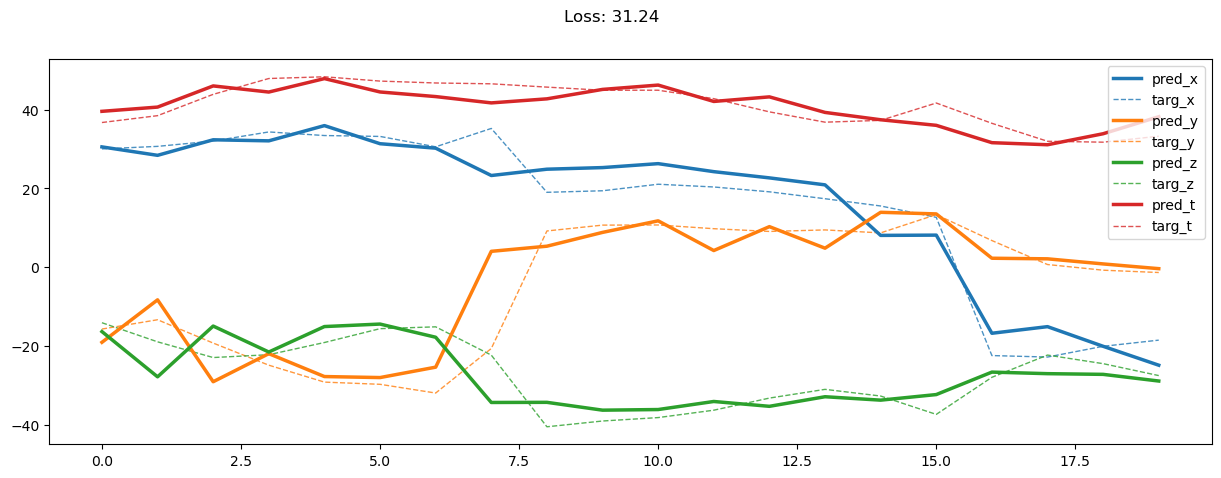

04000: train loss:  272.104, imu loss:  0.292, mag loss:  88.795, div loss:  177.453, slim:  6.559, tlim:  5.233
       valid loss:  141.726, imu loss:  0.296, mag loss:  50.905, div loss:  86.231, slim:  5.562, tlim:  3.871
04500: train loss:  252.962, imu loss:  0.291, mag loss:  83.281, div loss:  164.013, slim:  6.448, tlim:  5.020
       valid loss:  126.538, imu loss:  0.295, mag loss:  44.845, div loss:  77.299, slim:  5.374, tlim:  3.674


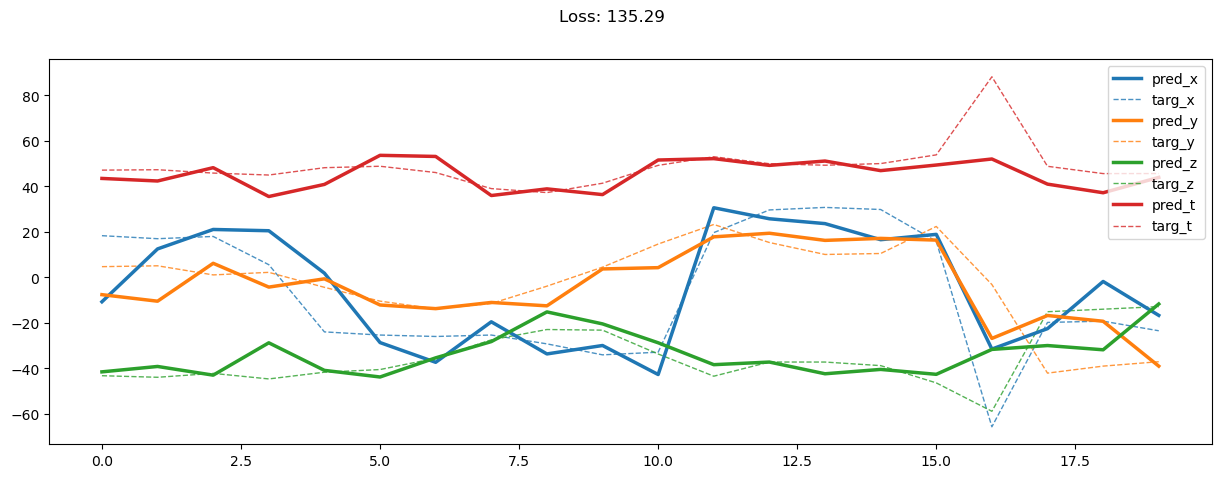

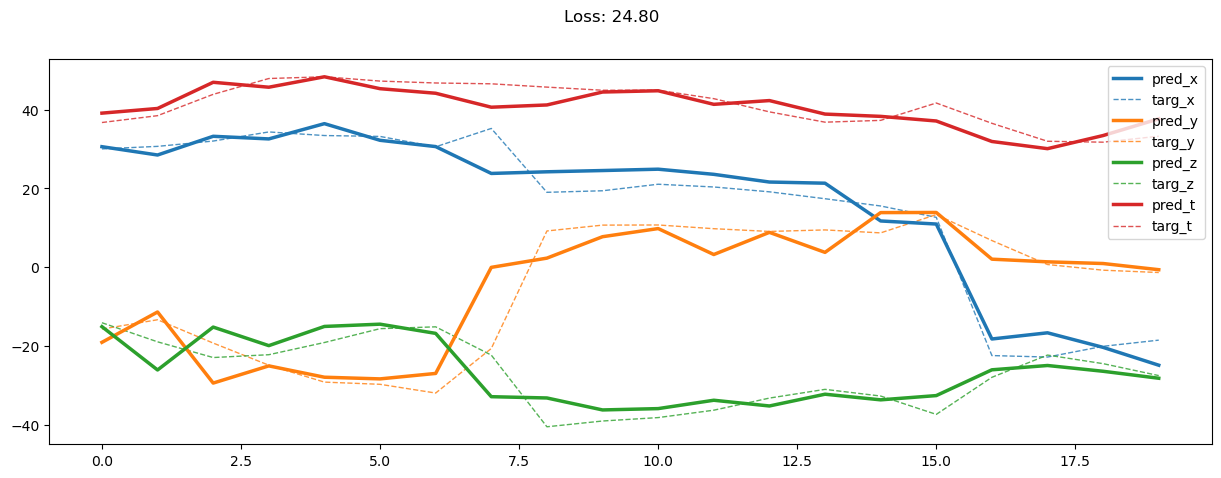

05000: train loss:  240.793, imu loss:  0.291, mag loss:  79.314, div loss:  155.864, slim:  6.376, tlim:  4.974
       valid loss:  117.098, imu loss:  0.293, mag loss:  41.557, div loss:  71.305, slim:  5.244, tlim:  3.508
05500: train loss:  225.096, imu loss:  0.291, mag loss:  73.714, div loss:  146.004, slim:  6.163, tlim:  4.729
       valid loss:  107.198, imu loss:  0.293, mag loss:  37.583, div loss:  65.503, slim:  5.167, tlim:  3.370


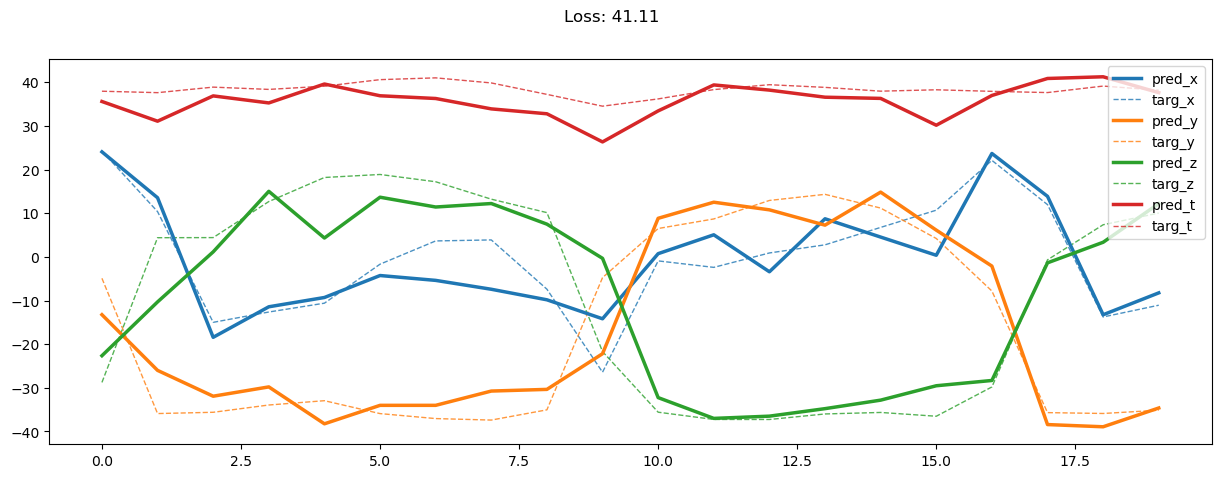

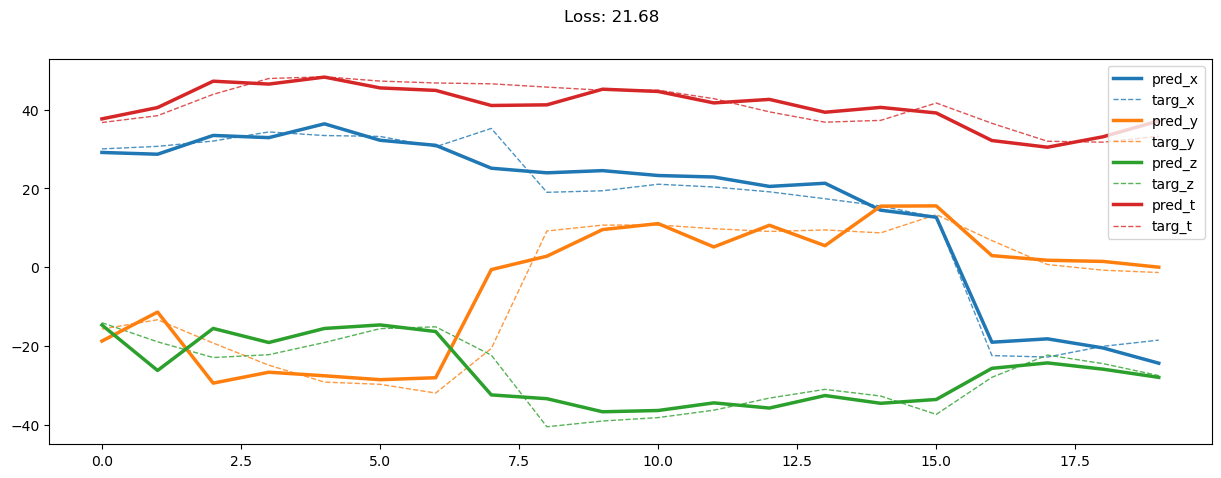

06000: train loss:  223.984, imu loss:  0.290, mag loss:  71.835, div loss:  146.891, slim:  6.122, tlim:  4.583
       valid loss:  99.990, imu loss:  0.292, mag loss:  34.742, div loss:  61.318, slim:  5.091, tlim:  3.154
06500: train loss:  201.523, imu loss:  0.288, mag loss:  65.304, div loss:  131.073, slim:  6.041, tlim:  4.464
       valid loss:  93.878, imu loss:  0.291, mag loss:  32.575, div loss:  57.458, slim:  5.027, tlim:  3.063


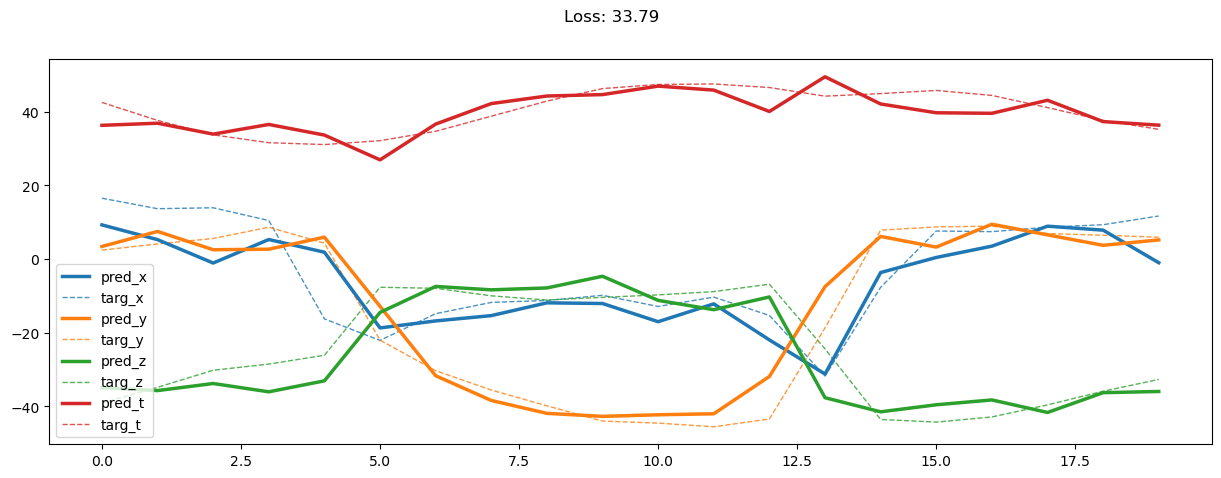

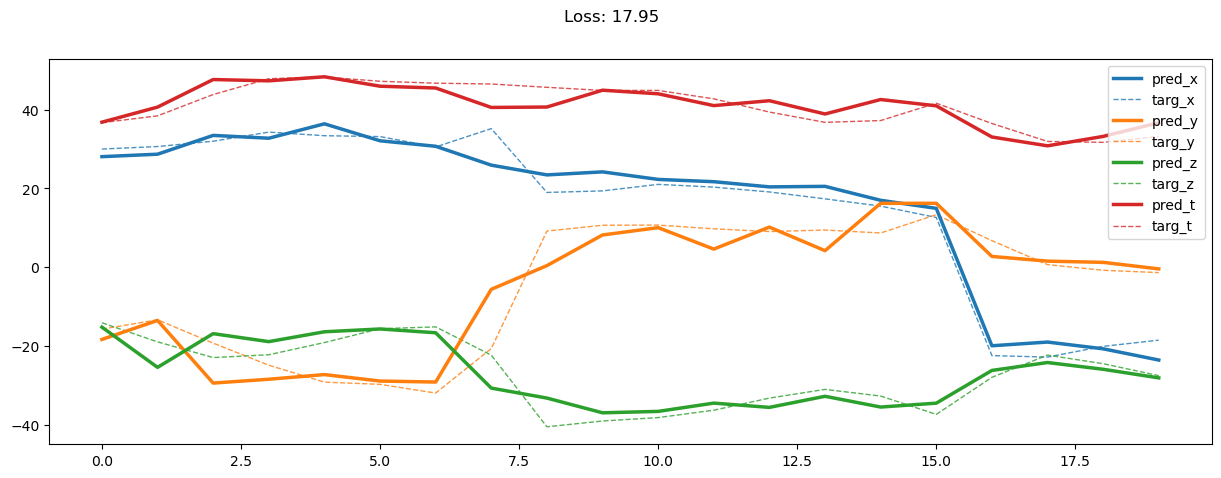

07000: train loss:  192.394, imu loss:  0.289, mag loss:  62.785, div loss:  124.630, slim:  5.942, tlim:  4.274
       valid loss:  86.808, imu loss:  0.291, mag loss:  29.847, div loss:  53.217, slim:  4.998, tlim:  2.939
07500: train loss:  180.938, imu loss:  0.289, mag loss:  58.382, div loss:  117.676, slim:  5.763, tlim:  4.201
       valid loss:  82.166, imu loss:  0.290, mag loss:  28.000, div loss:  50.508, slim:  4.915, tlim:  2.851


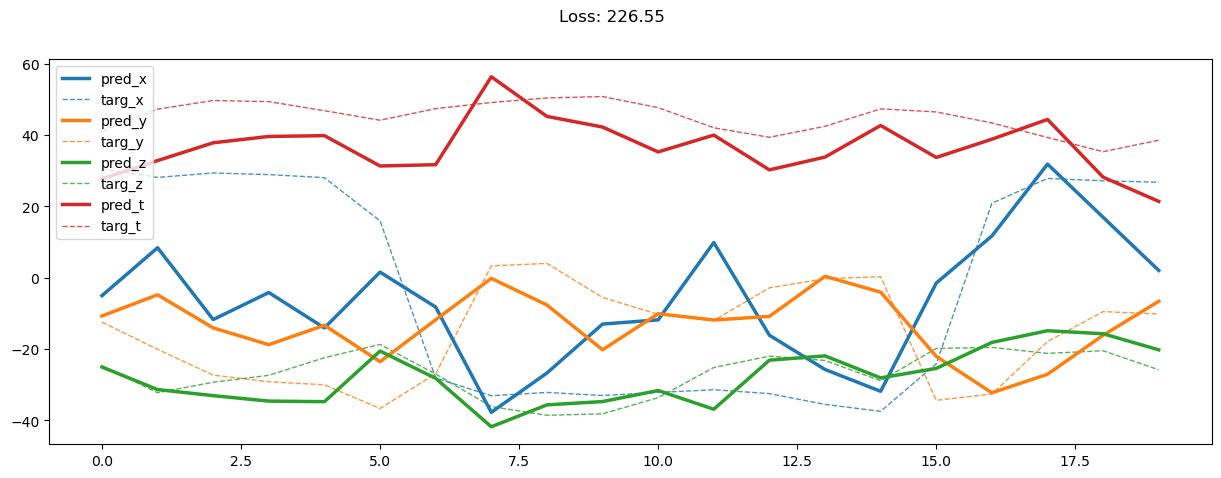

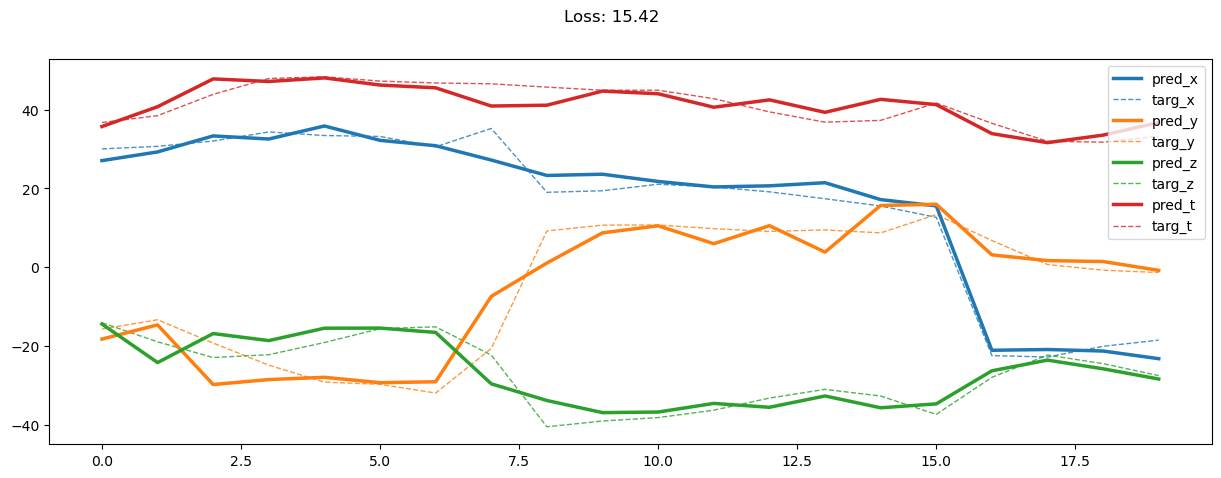

08000: train loss:  189.364, imu loss:  0.288, mag loss:  60.900, div loss:  123.603, slim:  5.763, tlim:  4.177
       valid loss:  77.753, imu loss:  0.289, mag loss:  26.384, div loss:  47.747, slim:  4.920, tlim:  2.803
08500: train loss:  169.224, imu loss:  0.288, mag loss:  55.729, div loss:  108.721, slim:  5.776, tlim:  4.056
       valid loss:  74.777, imu loss:  0.289, mag loss:  25.110, div loss:  46.128, slim:  4.879, tlim:  2.707


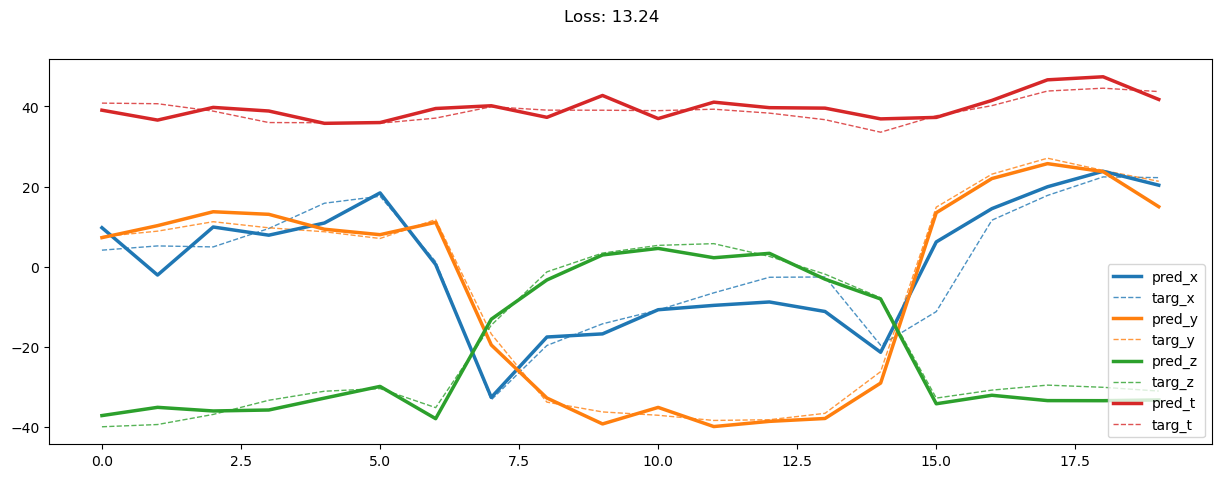

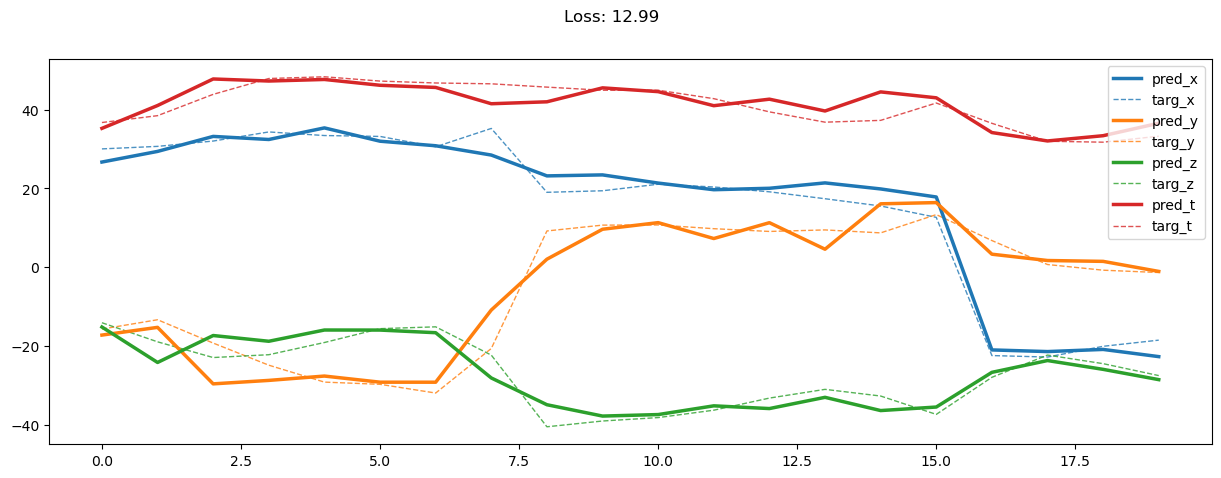

09000: train loss:  161.840, imu loss:  0.286, mag loss:  52.698, div loss:  104.422, slim:  5.698, tlim:  4.013
       valid loss:  70.622, imu loss:  0.288, mag loss:  23.574, div loss:  43.541, slim:  4.860, tlim:  2.673
09500: train loss:  156.098, imu loss:  0.286, mag loss:  50.384, div loss:  101.140, slim:  5.630, tlim:  3.841
       valid loss:  67.951, imu loss:  0.288, mag loss:  22.687, div loss:  41.788, slim:  4.850, tlim:  2.634


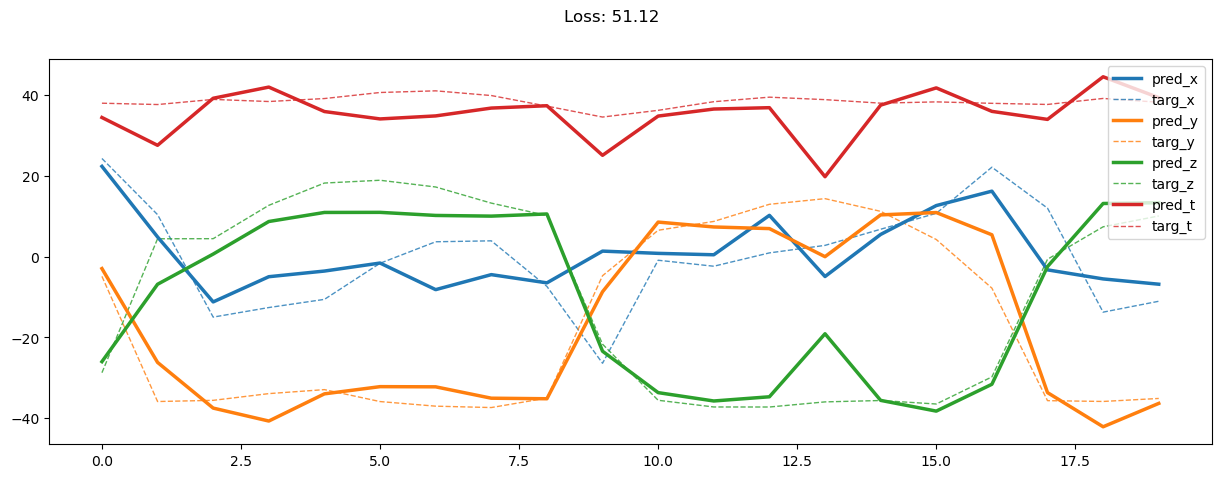

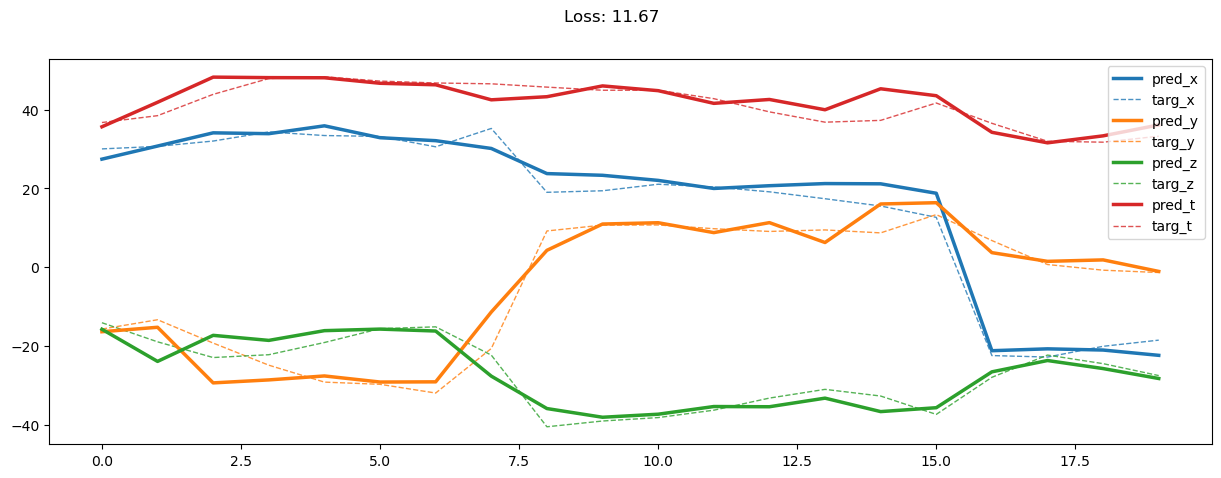

10000: train loss:  149.188, imu loss:  0.285, mag loss:  48.564, div loss:  96.080, slim:  5.522, tlim:  3.839
       valid loss:  64.838, imu loss:  0.287, mag loss:  21.606, div loss:  39.801, slim:  4.820, tlim:  2.584
10500: train loss:  157.077, imu loss:  0.285, mag loss:  50.153, div loss:  102.398, slim:  5.546, tlim:  3.805
       valid loss:  61.211, imu loss:  0.287, mag loss:  20.319, div loss:  37.507, slim:  4.791, tlim:  2.533


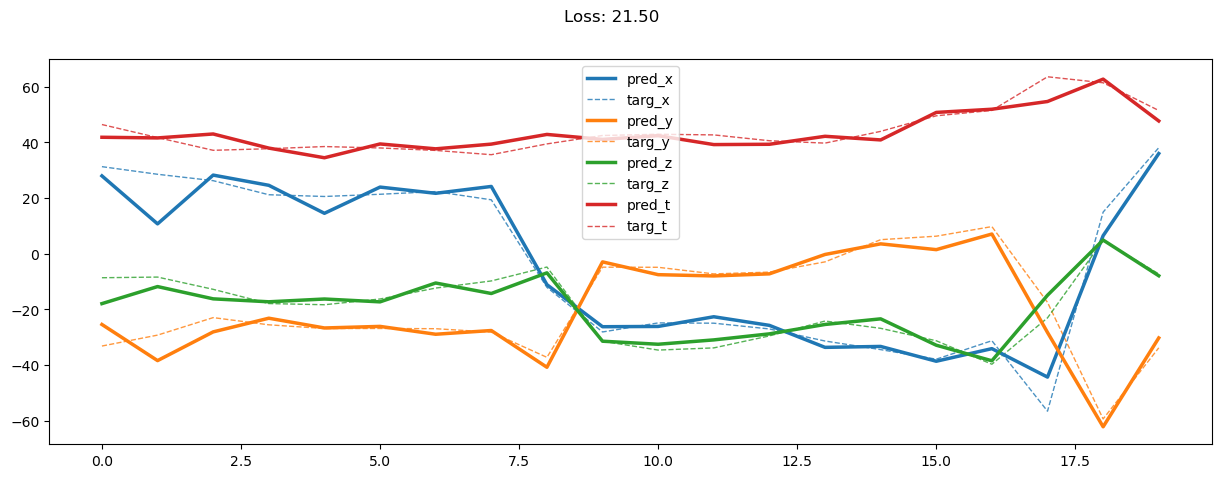

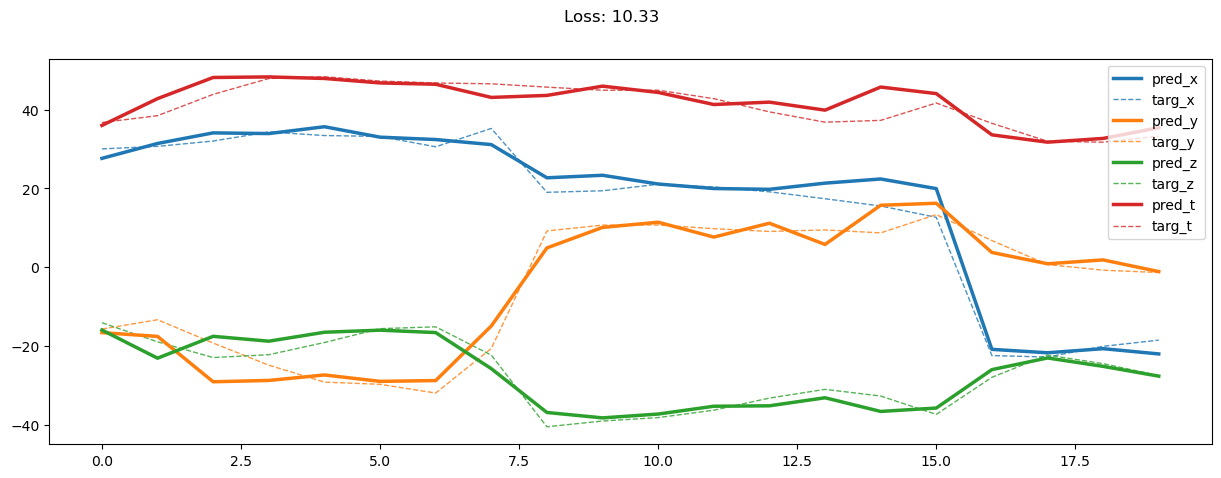

11000: train loss:  145.365, imu loss:  0.285, mag loss:  47.638, div loss:  93.305, slim:  5.443, tlim:  3.702
       valid loss:  59.297, imu loss:  0.287, mag loss:  19.631, div loss:  36.301, slim:  4.790, tlim:  2.508
11500: train loss:  143.827, imu loss:  0.285, mag loss:  46.374, div loss:  93.025, slim:  5.534, tlim:  3.679
       valid loss:  57.521, imu loss:  0.286, mag loss:  18.889, div loss:  35.296, slim:  4.772, tlim:  2.476


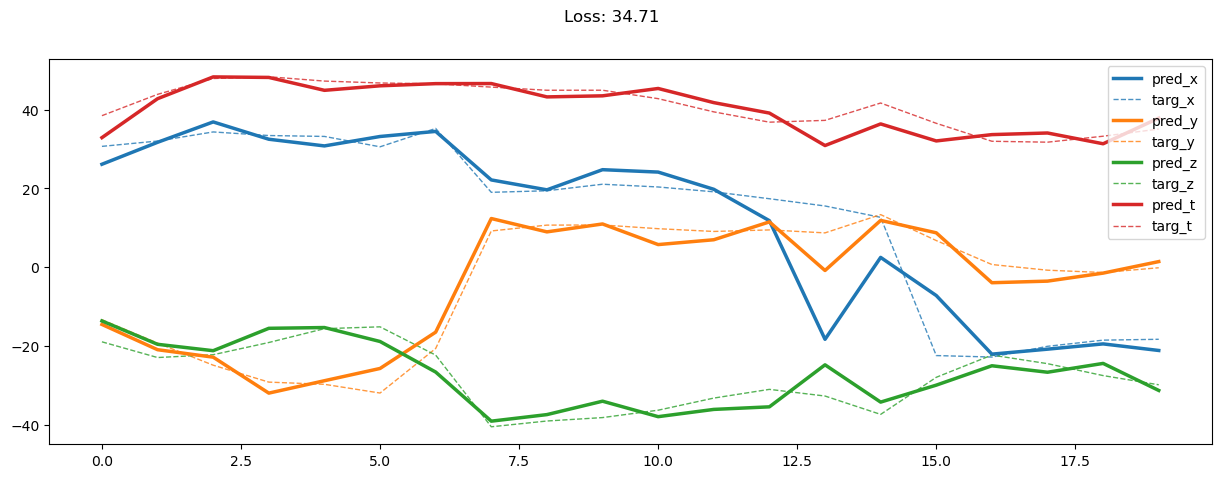

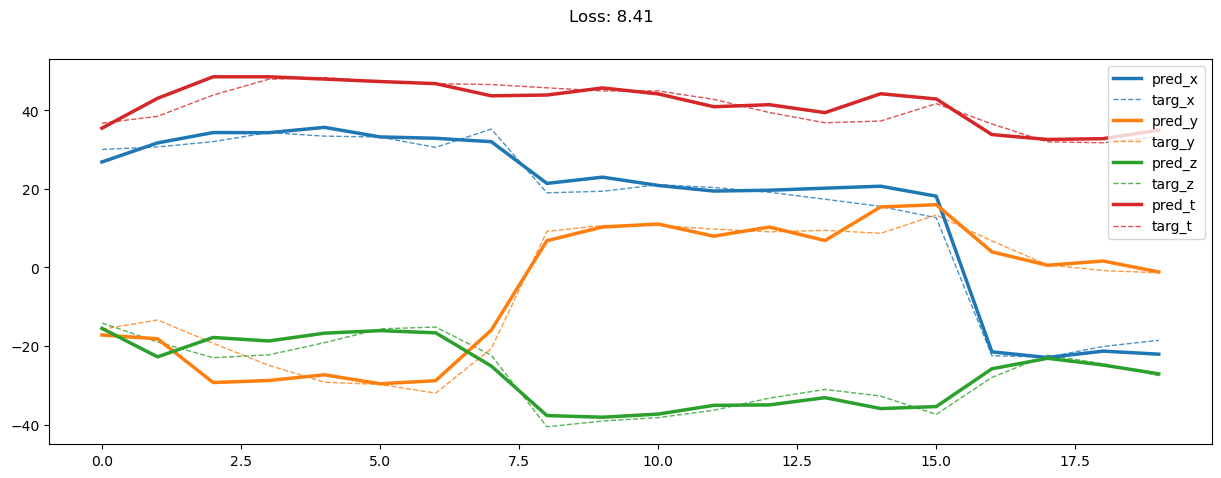

12000: train loss:  130.261, imu loss:  0.285, mag loss:  42.009, div loss:  83.987, slim:  5.378, tlim:  3.513
       valid loss:  54.461, imu loss:  0.286, mag loss:  17.893, div loss:  33.275, slim:  4.750, tlim:  2.427
12500: train loss:  130.558, imu loss:  0.285, mag loss:  42.177, div loss:  84.085, slim:  5.406, tlim:  3.546
       valid loss:  53.008, imu loss:  0.285, mag loss:  17.180, div loss:  32.612, slim:  4.724, tlim:  2.334


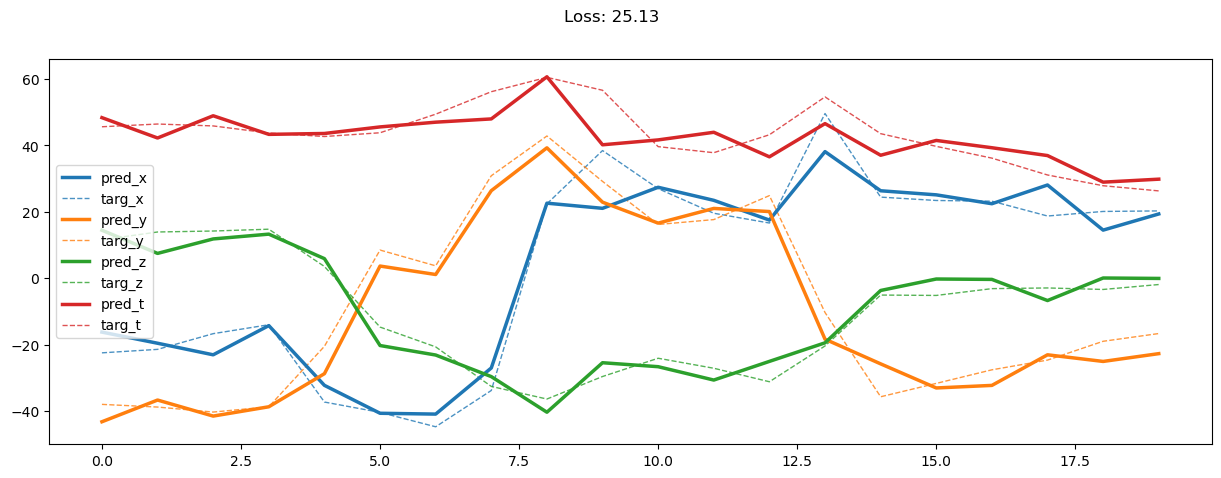

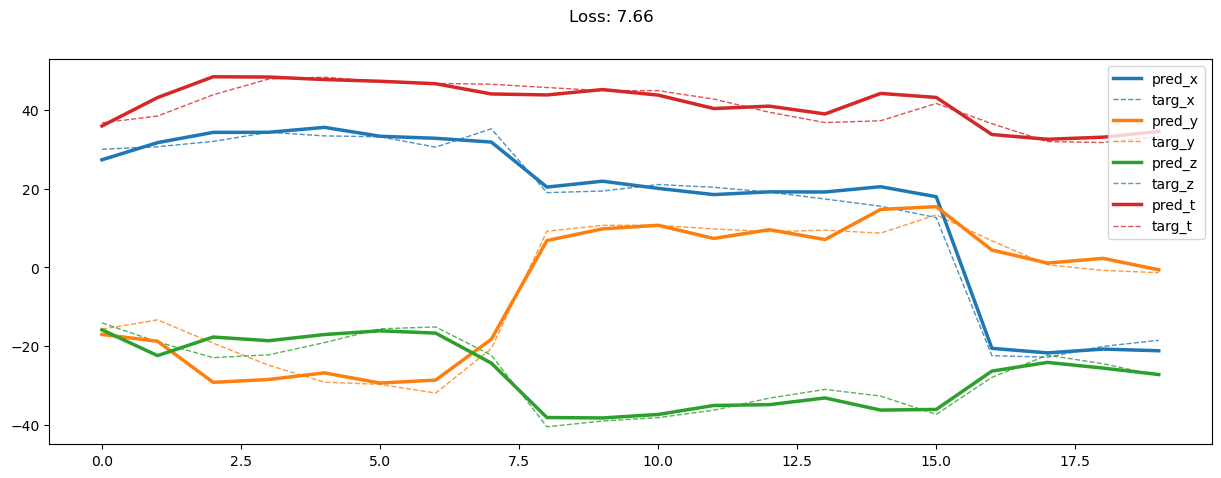

13000: train loss:  122.251, imu loss:  0.284, mag loss:  39.281, div loss:  78.820, slim:  5.286, tlim:  3.394
       valid loss:  51.388, imu loss:  0.285, mag loss:  16.616, div loss:  31.569, slim:  4.714, tlim:  2.321
13500: train loss:  117.537, imu loss:  0.285, mag loss:  38.223, div loss:  75.131, slim:  5.301, tlim:  3.431
       valid loss:  49.644, imu loss:  0.284, mag loss:  16.137, div loss:  30.295, slim:  4.725, tlim:  2.329


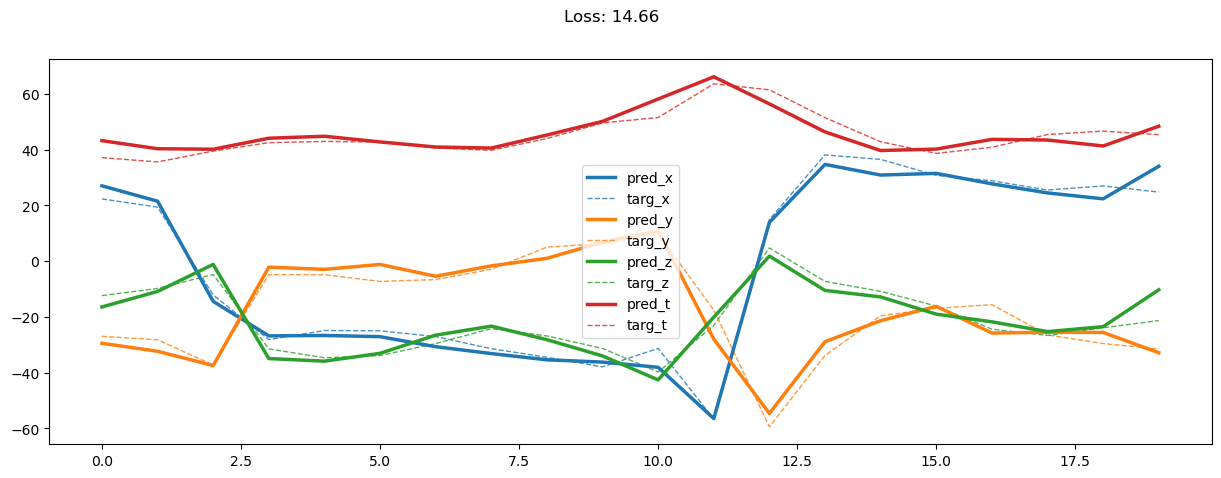

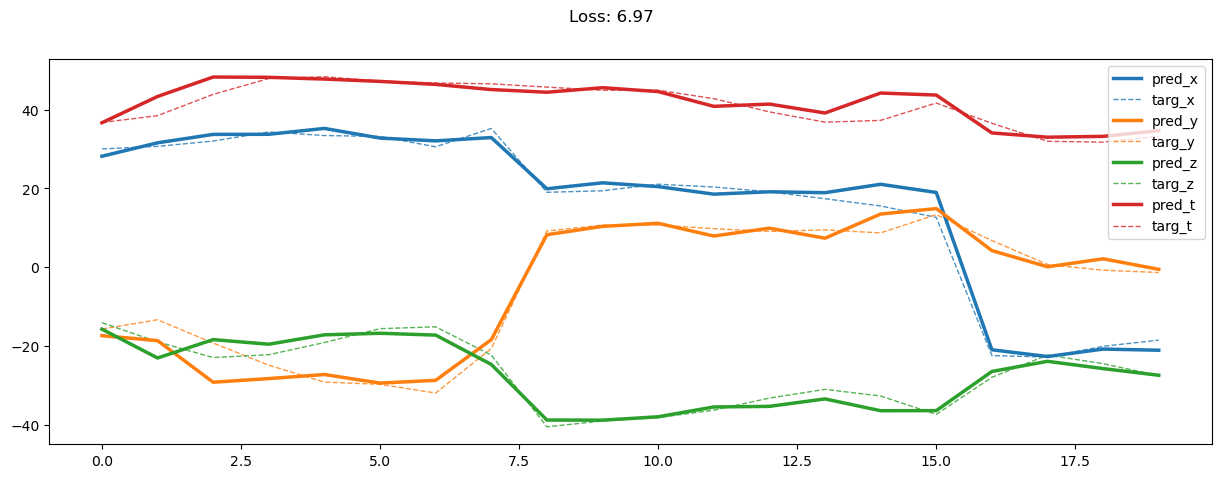

14000: train loss:  119.829, imu loss:  0.282, mag loss:  38.575, div loss:  77.160, slim:  5.267, tlim:  3.326
       valid loss:  47.228, imu loss:  0.283, mag loss:  15.297, div loss:  28.777, slim:  4.687, tlim:  2.266
14500: train loss:  115.439, imu loss:  0.283, mag loss:  37.078, div loss:  74.288, slim:  5.305, tlim:  3.285
       valid loss:  45.208, imu loss:  0.283, mag loss:  14.486, div loss:  27.565, slim:  4.687, tlim:  2.271


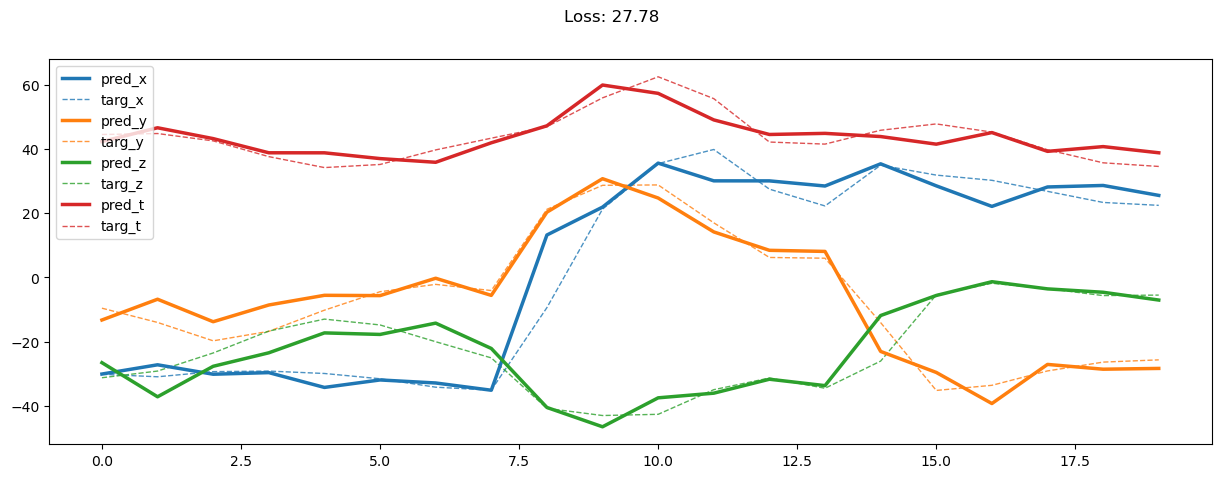

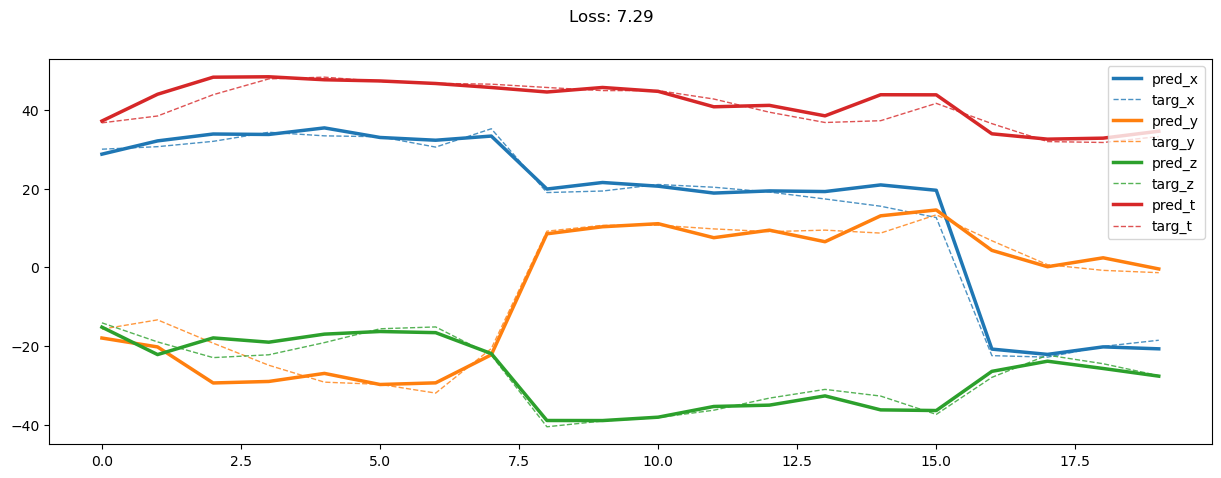

15000: train loss:  110.053, imu loss:  0.282, mag loss:  35.677, div loss:  70.357, slim:  5.211, tlim:  3.246
       valid loss:  44.040, imu loss:  0.282, mag loss:  14.120, div loss:  26.852, slim:  4.627, tlim:  2.172
15500: train loss:  110.612, imu loss:  0.282, mag loss:  35.033, div loss:  71.552, slim:  5.238, tlim:  3.248
       valid loss:  42.926, imu loss:  0.281, mag loss:  13.802, div loss:  26.032, slim:  4.654, tlim:  2.196


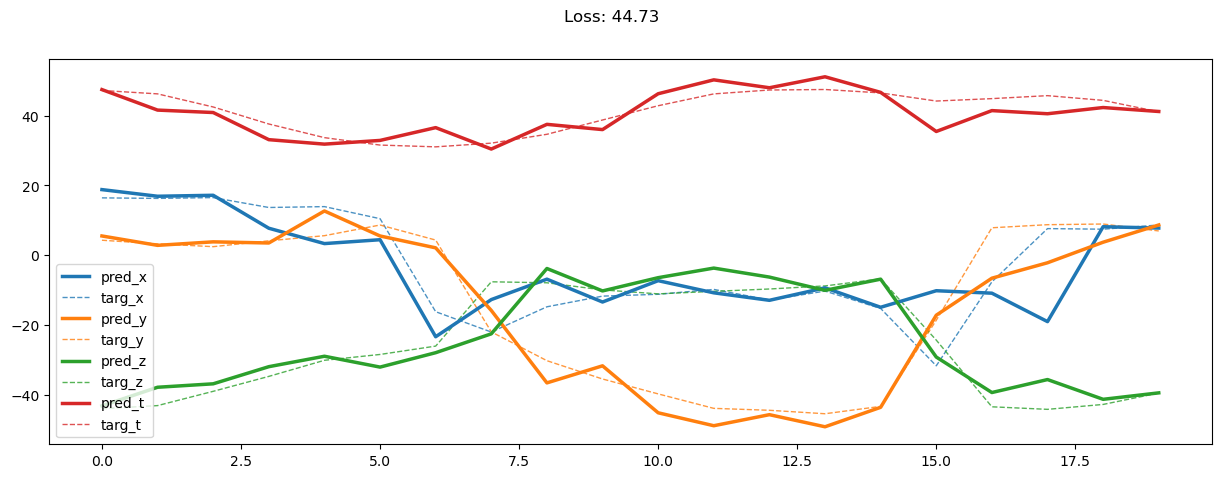

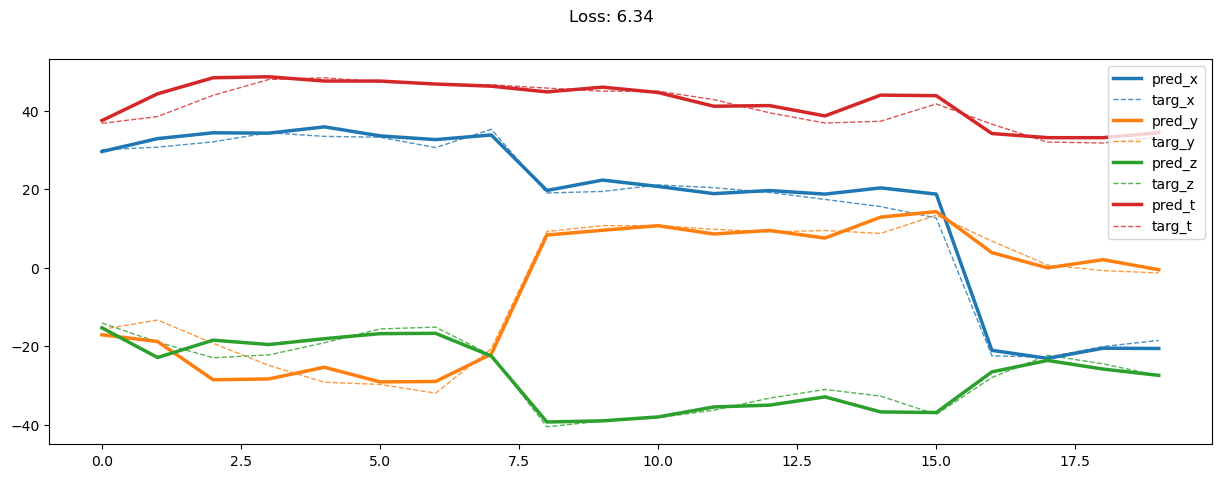

16000: train loss:  104.235, imu loss:  0.281, mag loss:  33.531, div loss:  66.708, slim:  5.206, tlim:  3.218
       valid loss:  42.367, imu loss:  0.281, mag loss:  13.550, div loss:  25.769, slim:  4.637, tlim:  2.145
16500: train loss:  103.750, imu loss:  0.283, mag loss:  33.163, div loss:  66.680, slim:  5.161, tlim:  3.112
       valid loss:  39.538, imu loss:  0.281, mag loss:  12.548, div loss:  24.021, slim:  4.564, tlim:  2.064


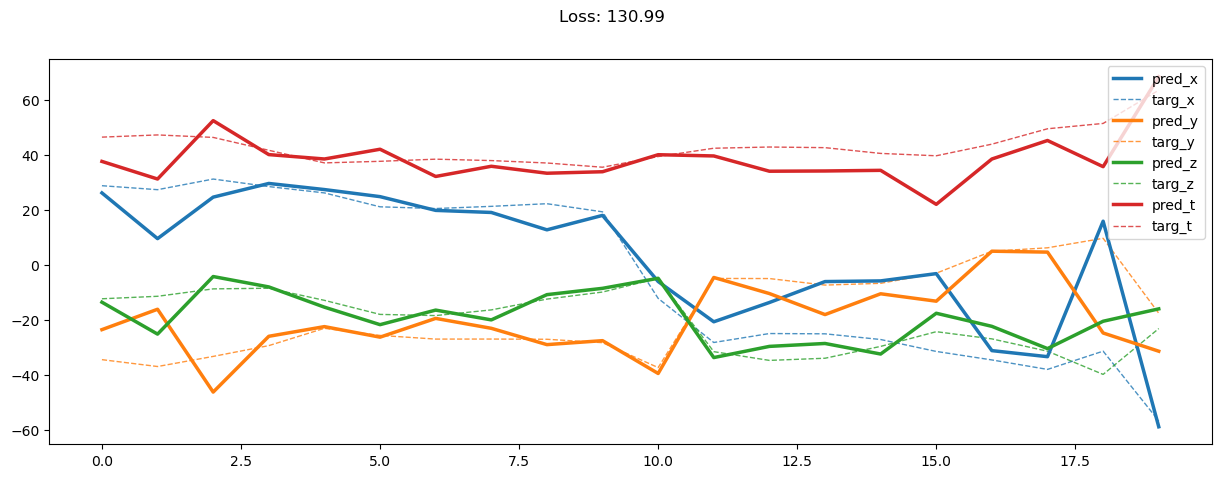

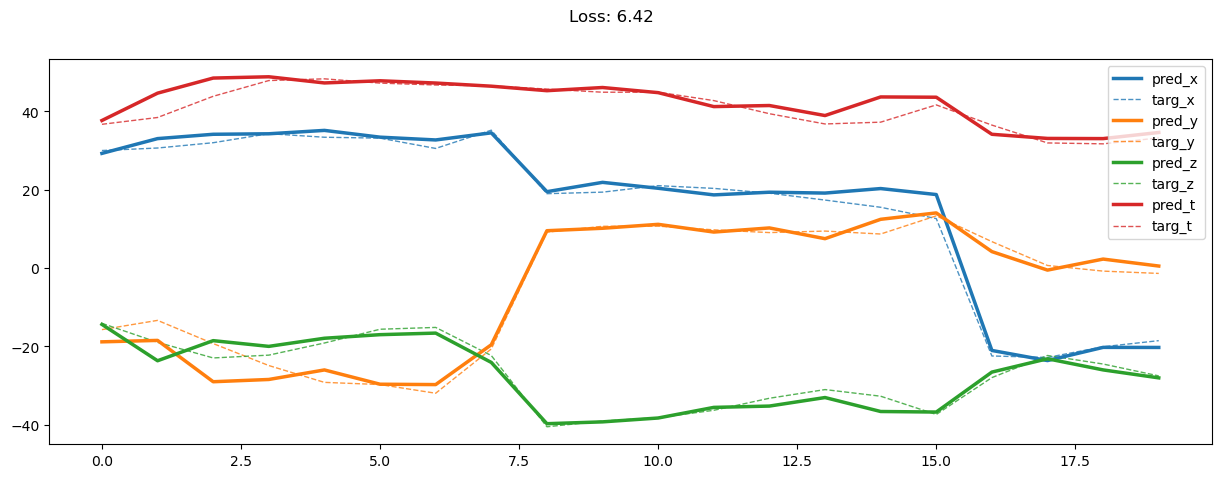

17000: train loss:  101.006, imu loss:  0.280, mag loss:  32.791, div loss:  64.307, slim:  5.116, tlim:  3.133
       valid loss:  38.891, imu loss:  0.280, mag loss:  12.389, div loss:  23.531, slim:  4.589, tlim:  2.058
17500: train loss:  95.648, imu loss:  0.282, mag loss:  30.495, div loss:  61.354, slim:  5.067, tlim:  3.001
       valid loss:  37.584, imu loss:  0.280, mag loss:  11.981, div loss:  22.577, slim:  4.600, tlim:  2.128


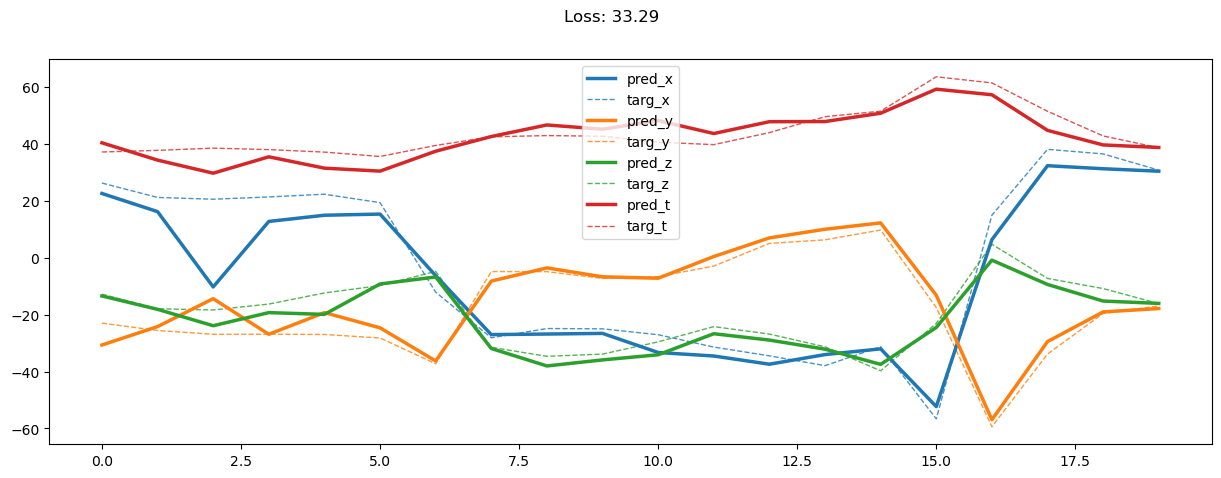

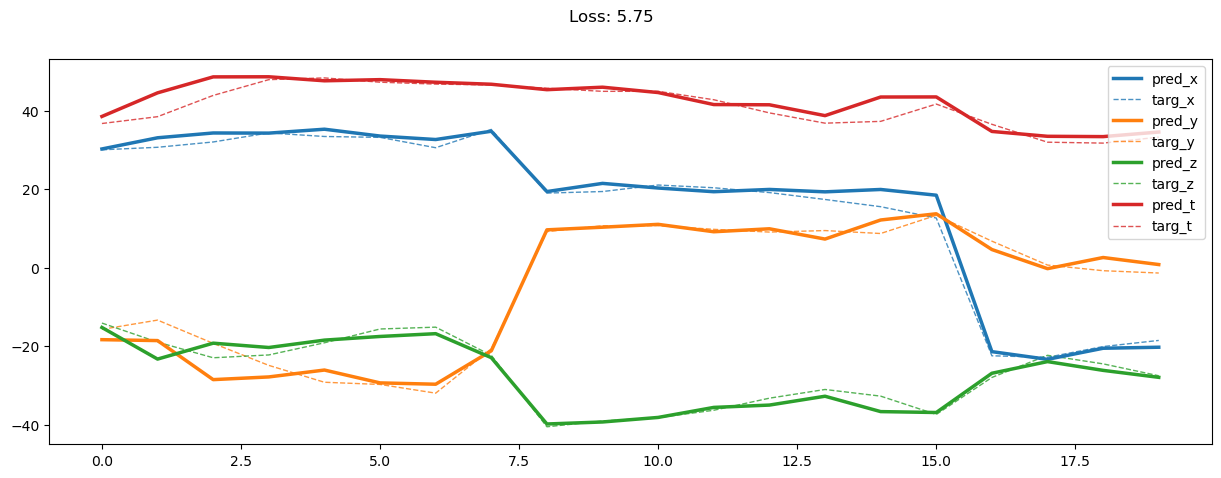

18000: train loss:  99.124, imu loss:  0.280, mag loss:  31.937, div loss:  63.421, slim:  5.005, tlim:  2.978
       valid loss:  36.793, imu loss:  0.280, mag loss:  11.573, div loss:  22.263, slim:  4.574, tlim:  2.044
18500: train loss:  100.817, imu loss:  0.280, mag loss:  32.594, div loss:  64.391, slim:  5.057, tlim:  3.050
       valid loss:  36.416, imu loss:  0.279, mag loss:  11.567, div loss:  21.880, slim:  4.553, tlim:  2.068


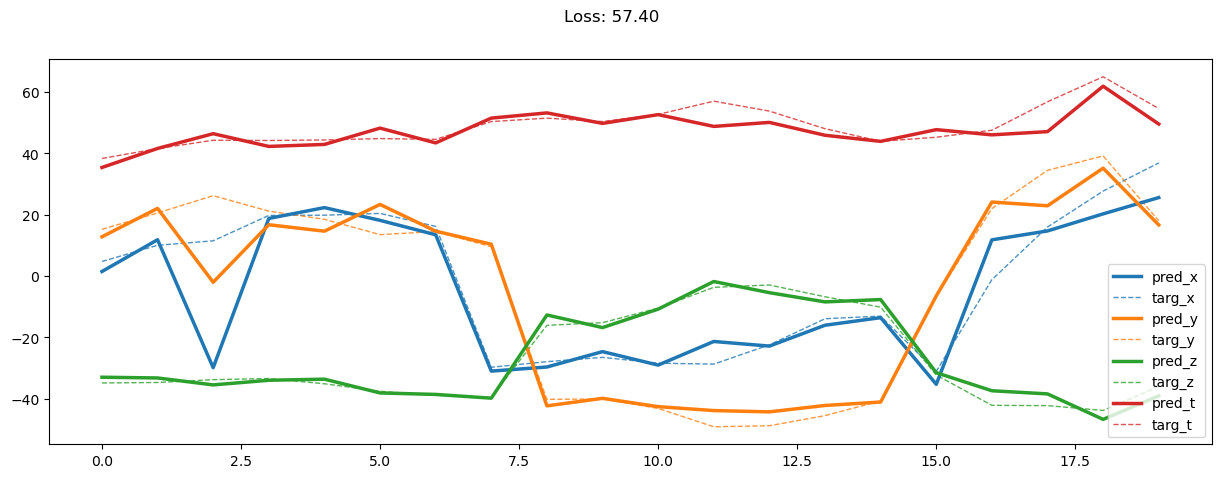

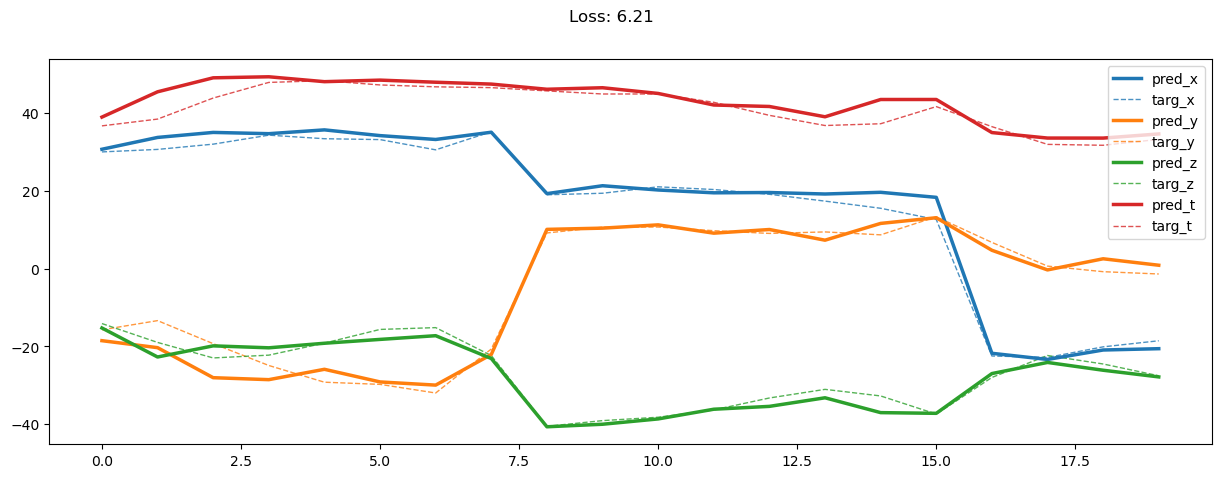

19000: train loss:  90.838, imu loss:  0.279, mag loss:  29.349, div loss:  57.772, slim:  5.019, tlim:  2.911
       valid loss:  35.613, imu loss:  0.279, mag loss:  11.272, div loss:  21.338, slim:  4.618, tlim:  2.092
19500: train loss:  94.386, imu loss:  0.279, mag loss:  30.060, div loss:  60.610, slim:  4.980, tlim:  2.922
       valid loss:  34.119, imu loss:  0.279, mag loss:  10.715, div loss:  20.514, slim:  4.520, tlim:  1.975


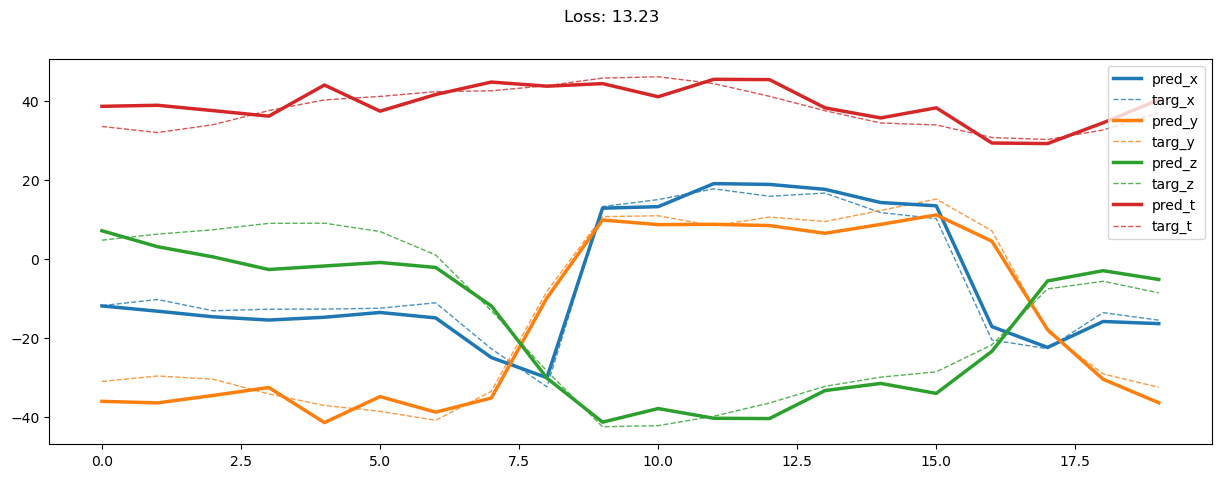

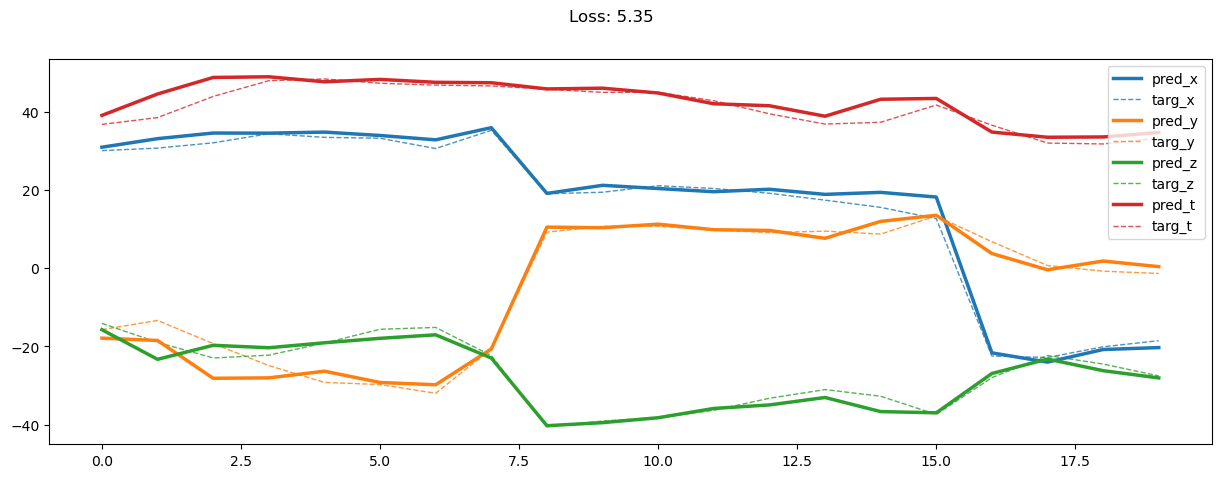

20000: train loss:  88.414, imu loss:  0.278, mag loss:  28.468, div loss:  56.297, slim:  4.936, tlim:  2.849
       valid loss:  33.609, imu loss:  0.278, mag loss:  10.556, div loss:  20.162, slim:  4.505, tlim:  1.982


In [25]:
EPOCH = 20000
draw = True

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 1000 == 0:
        draw = True
    
    train_loss, train_imu_loss, train_mag_loss, t_d1_loss, tlim_loss = train(train_loader, draw)
    valid_loss, valid_imu_loss, valid_mag_loss, v_d1_loss, vlim_loss = evalute(valid_loader, draw)
    
    draw = False
    
    if (epoch + 1) % 500 == 0:
        ep = str(epoch + 1).zfill(5)
        print(f'{ep:>5}: train loss: {train_loss: 2.3f}, imu loss: {train_imu_loss: 2.3f}, mag loss: {train_mag_loss: 2.3f}, div loss: {t_d1_loss: 2.3f}, slim: {tlim_loss[0]: 2.3f}, tlim: {tlim_loss[1]: 2.3f}\n' +
              f'{"":>5}  valid loss: {valid_loss: 2.3f}, imu loss: {valid_imu_loss: 2.3f}, mag loss: {valid_mag_loss: 2.3f}, div loss: {v_d1_loss: 2.3f}, slim: {vlim_loss[0]: 2.3f}, tlim: {vlim_loss[1]: 2.3f}')

In [26]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    class_results = []
    class_labels = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            source_pos = source_data[:, :, :2]
            source_imu = source_data[:, :, 2:8]
            source_mag = source_data[:, :, 8:11]

            target_data = target_data.to(device)
            target_pos = target_data[:, :, :2]
            target_imu = target_data[:, :, 2:8]
            target_mag = target_data[:, :, 8:11]

            # generate mag
            z_imu, predict_mag = model(source_imu, source_mag)

            # generator loss
#             gen_loss, imu_loss, mag_loss = generator_loss(z_imu, target_imu, predict_mag, target_mag)

            # record loss
            predict_mag = predict_mag.detach().cpu().numpy()
            target_pos = target_pos.detach().cpu().numpy()
            target_mag = target_mag.cpu().numpy()
            source_label = source_label.detach().cpu().numpy()
            
            results.extend(zip(predict_mag, target_mag, source_label, target_pos))
            
            diff = np.power(predict_mag.reshape(len(predict_mag), -1, 3) - target_mag.reshape(len(target_mag), -1, 3), 2).mean(axis=1)
            class_results.extend(diff)
            class_labels.extend(source_label)
    
    return np.array(results, dtype=object), np.array(class_results), np.array(class_labels)

In [27]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    source_label = result[2]
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{classes[source_label]}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

(248, 4) (248, 3) (248,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     6.32     7.77     5.14     6.41
     horizontal loss:    24.72    17.93    11.98    18.21
         pocket loss:     7.36     8.63     7.20     7.73
          swing loss:     4.74     6.10     4.73     5.19
        average loss:    10.79    10.11     7.26     9.39


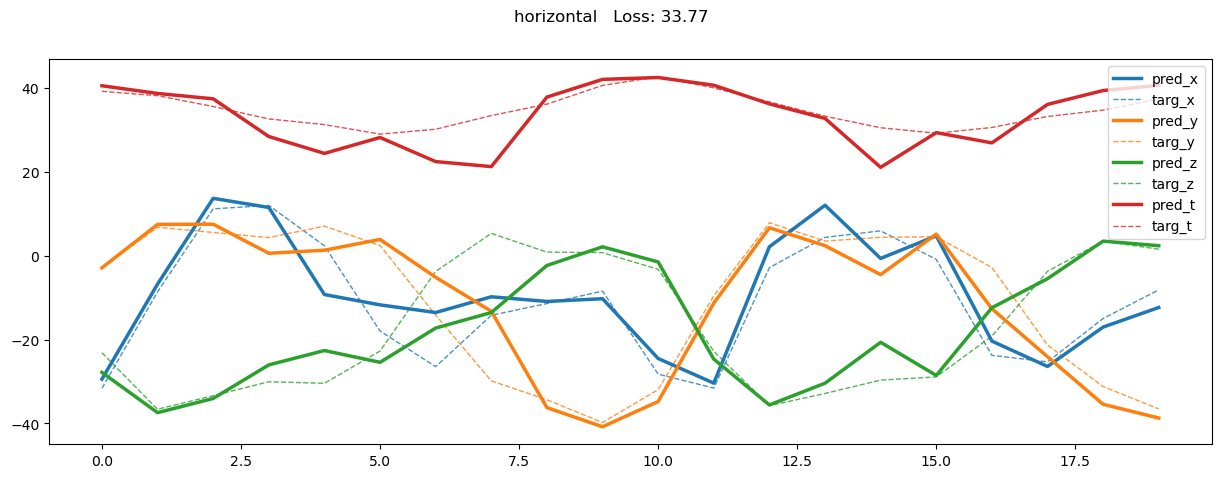

In [28]:
results, cres, clabel = output_eval(model, train_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::500]:
    plot_result(rs)

(244, 4) (244, 3) (244,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:     7.65     7.95     5.03     6.88
     horizontal loss:    26.75    24.13    16.08    22.32
         pocket loss:     8.04     9.34     7.87     8.42
          swing loss:     4.75     6.92     5.03     5.57
        average loss:    11.80    12.08     8.50    10.80


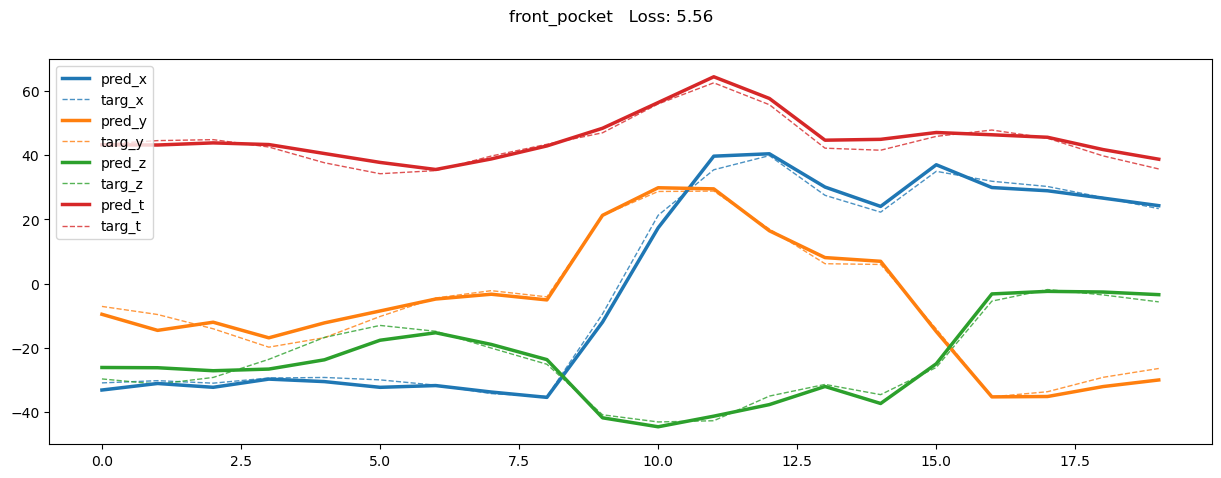

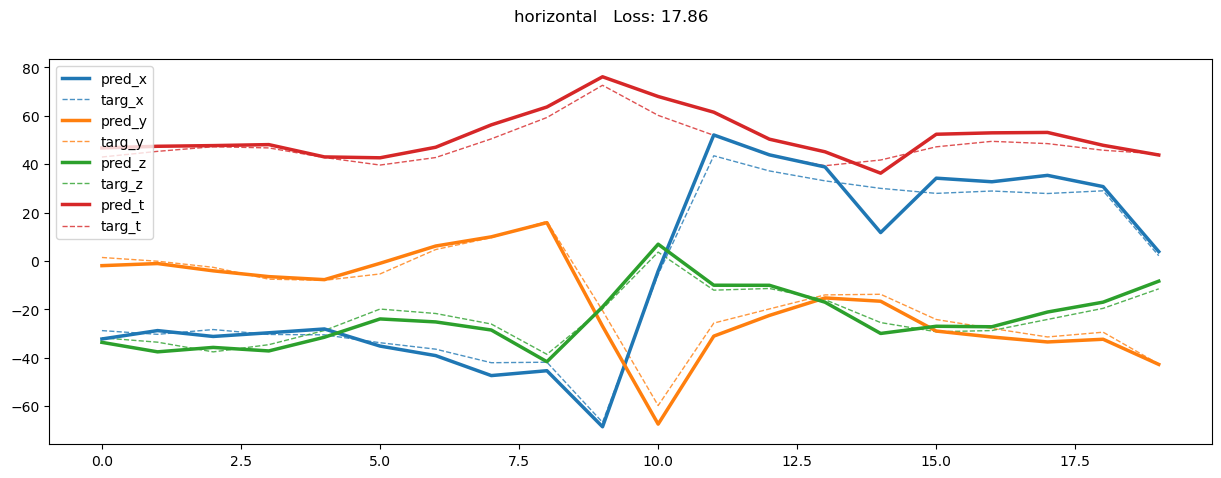

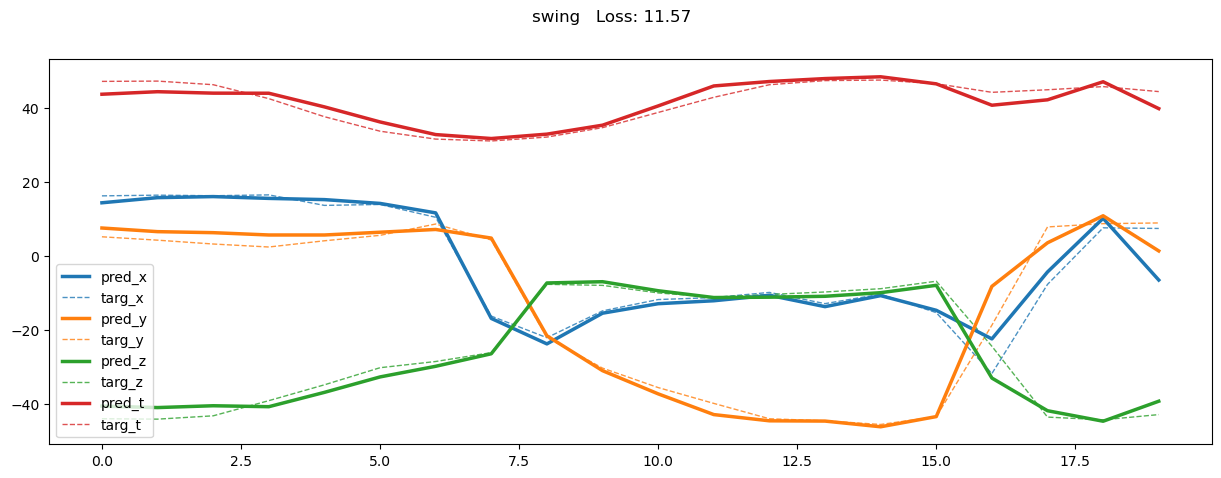

In [29]:
results, cres, clabel = output_eval(model, valid_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)

In [30]:
# classes = {0: 'target', 1: 'front_pocket', 2: 'horizontal', 3: 'pocket', 4: 'swing'}

In [31]:
pred_results = {}

get_posture = lambda x, y: np.concatenate((list(results[results[:, 2] == y, 3]), list(results[results[:, 2] == y, 0])), axis=-1)

pred_results['target'] = prep_valid_target_traj[:, :, [0, 1, 8, 9, 10]]
pred_results['front_pocket'] = get_posture(results, 1)
pred_results['horizontal'] = get_posture(results, 2)
pred_results['pocket'] = get_posture(results, 3)
pred_results['swing'] = get_posture(results, 4)

In [32]:
pred_results['target'].shape, pred_results['front_pocket'].shape, pred_results['horizontal'].shape, pred_results['pocket'].shape, pred_results['swing'].shape

((123, 20, 5), (61, 20, 5), (61, 20, 5), (61, 20, 5), (61, 20, 5))

In [33]:
np.save(f'./pred_results.npy', pred_results)

In [34]:
def plot_eval_result(result, path):
    pred_mag = np.stack(results[:, 0], axis=0)[:, 0].reshape(-1, 3)
    targ_mag = np.stack(results[:, 1], axis=0)[:, 0].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(25, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    pred_total_mag = np.sqrt(np.sum(np.power(pred_mag, 2), axis=-1))
    targ_total_mag = np.sqrt(np.sum(np.power(targ_mag, 2), axis=-1))
    plt.plot(x, pred_total_mag, label=f'pred_t', color='tab:red', linewidth=2.5, zorder=2)
    plt.plot(x, targ_total_mag, '--', label=f'targ_t', color='tab:red', linewidth=1, alpha=0.8, zorder=1)
    
    plt.suptitle(f'{path}   Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [35]:
def load_data(name):
    return posture_data[name], posture_data['target']

def split_data(df):
    ncols = seq_len
    nrows = len(df) - seq_len + 1
    
    index = np.zeros((nrows, ncols), dtype=int)
    index += np.arange(ncols)
    index += np.arange(nrows).T[:, None]
    
    return df.to_numpy()[index]    

def combine_to_dataloader(source, target):
    dataset = PairDataset(
                        source_data = torch.tensor(source, dtype=torch.float),
                        source_label = np.zeros(len(source)),
                        target_data = torch.tensor(target, dtype=torch.float),
                        target_label = np.zeros(len(target)),
                    )
    dataloader = DataLoader(dataset, batch_size=512, shuffle=False)
    
    return dataloader

def generate_dataloader(name):
    source_df, target_df = load_data(name)
    source_segs, target_segs = split_data(source_df), split_data(target_df)

    return combine_to_dataloader(source_segs, target_segs)

In [36]:
for folder in ['./front_pocket/*', './pocket/*', './swing/*']:
    for path in glob.glob(folder):
        eval_loader = generate_dataloader(name)
        results, _, _ = output_eval(model, eval_loader)
        plot_eval_result(results, path)

In [37]:
print(1)

1


In [38]:
torch.save(model, 'transformer.pt')

In [39]:
model = torch.load('/root/Calibration/R403/transformer.pt')

(248, 4) (248, 3) (248,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:   716.03   483.24   207.26   468.84
     horizontal loss:  1175.04   734.88   332.06   747.32
         pocket loss:  1838.76   833.92   293.15   988.61
          swing loss:   671.12   417.42   231.29   439.94
        average loss:  1100.24   617.37   265.94   661.18


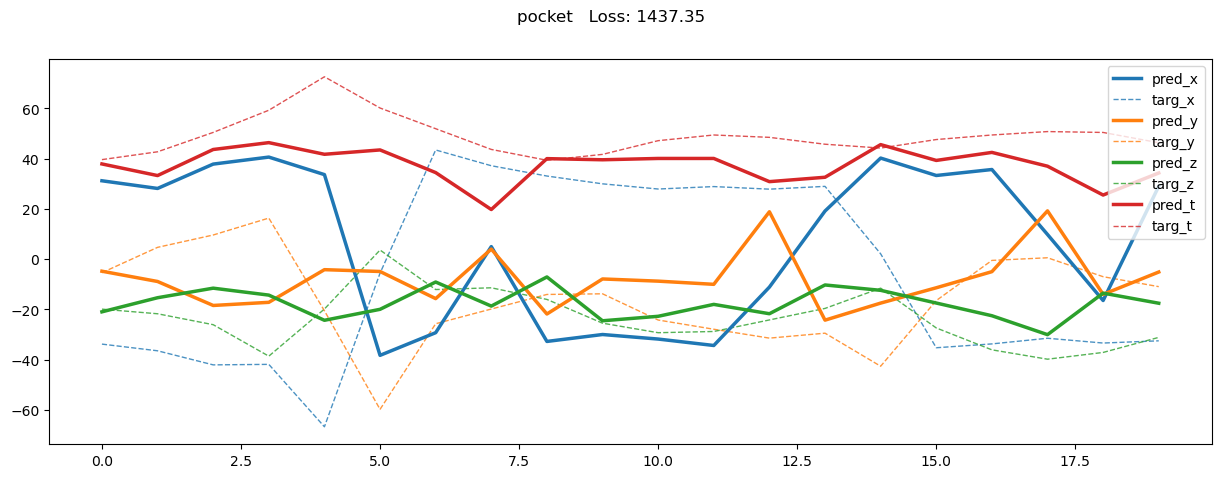

In [40]:
results, cres, clabel = output_eval(model, train_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::500]:
    plot_result(rs)

(244, 4) (244, 3) (244,)
           loss name|   diff x   diff y   diff z      avg
   front_pocket loss:   674.45   460.84   202.43   445.91
     horizontal loss:  1148.07   716.19   330.36   731.54
         pocket loss:  1765.00   820.45   293.83   959.76
          swing loss:   666.70   413.35   225.83   435.29
        average loss:  1063.55   602.71   263.11   643.12


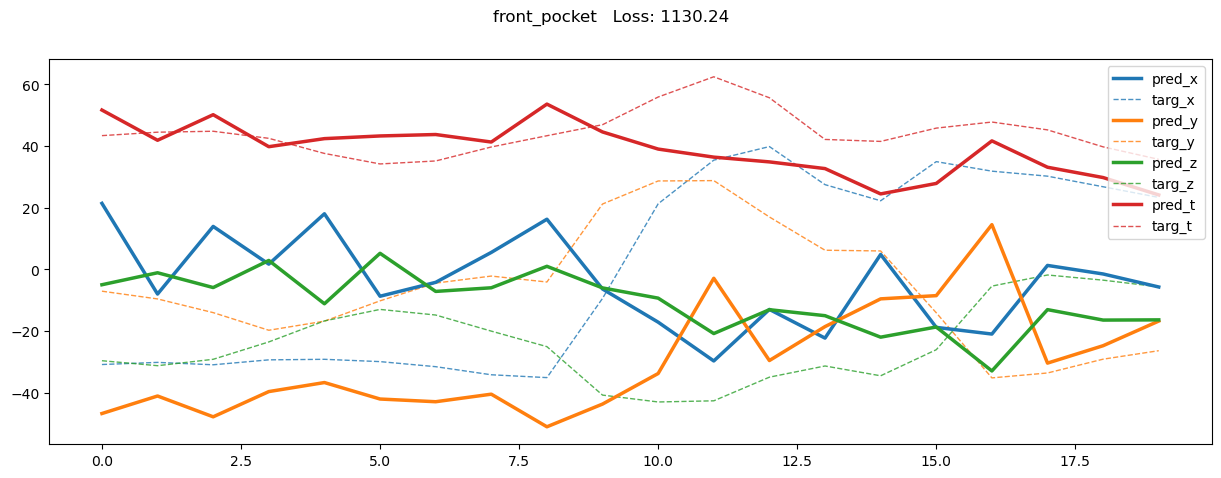

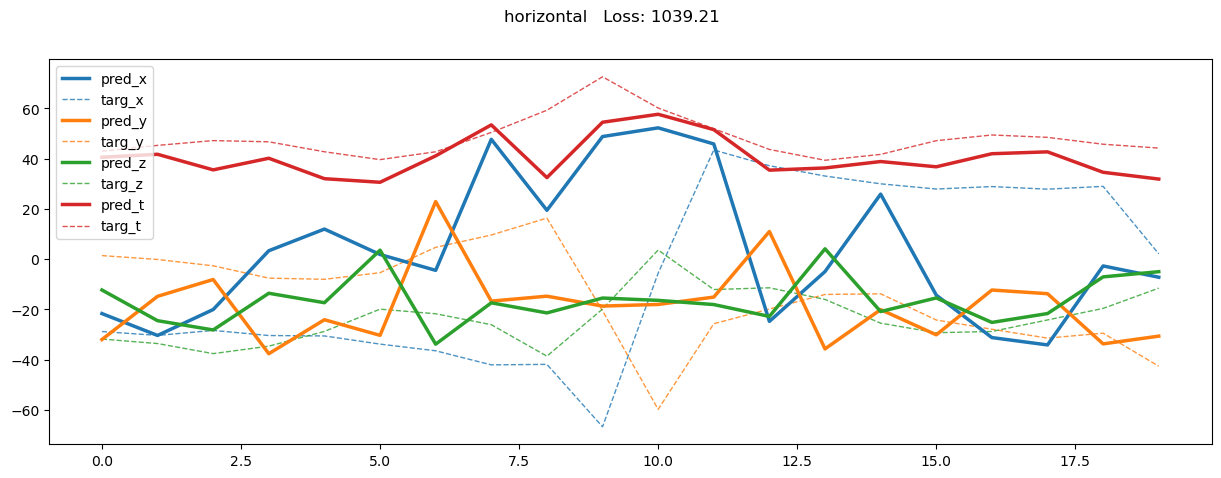

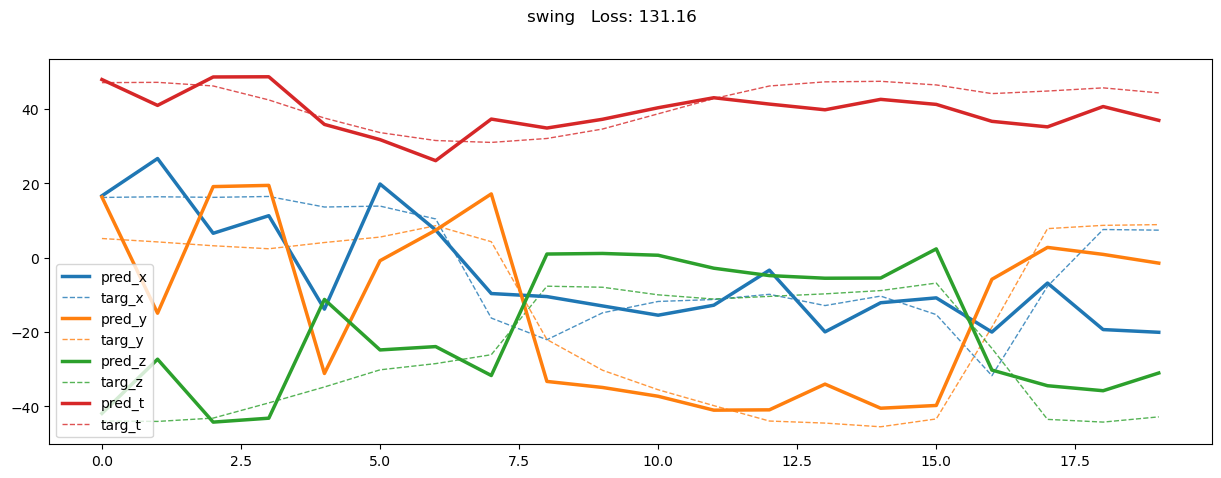

In [41]:
results, cres, clabel = output_eval(model, valid_loader)
print(results.shape, cres.shape, clabel.shape)

print(f'{"loss name":>20}| {"diff x":>8} {"diff y":>8} {"diff z":>8} {"avg":>8}')
for class_label, class_name in classes.items():
    if sum(clabel == class_label) <= 0:
        continue
    dx, dy, dz = cres[clabel == class_label].mean(axis=0)
    print(f'{class_name:>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')
dx, dy, dz = cres.mean(axis=0)
print(f'{"average":>15} loss: {dx:>8.2f} {dy:>8.2f} {dz:>8.2f} {np.mean([dx, dy, dz]):>8.2f}')

for rs in results[::100]:
    plot_result(rs)